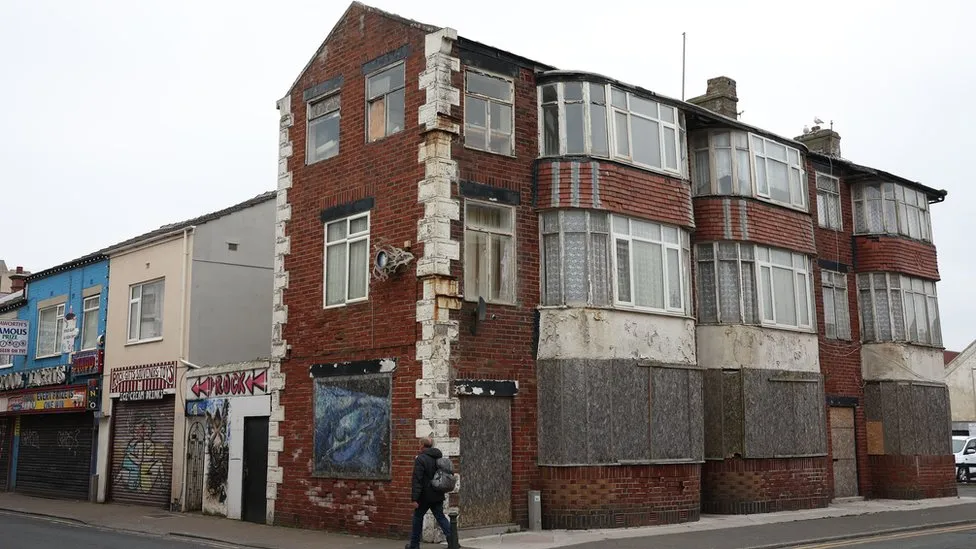

### Import Packages

In [1]:
import pandas as pd 
import numpy as np
import glob
import scipy.stats
from scipy.stats import chi2_contingency

import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from bokeh.plotting import figure, output_notebook, show, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.embed import file_html
from bokeh.resources import CDN


output_notebook()


import pycountry
import geopandas as gpd

Loading BokehJS ...

### Pycountry & Openpyxl - Uncomment the code below

In [2]:
# pip install openpyxl

In [3]:
# pip install pycountry

In [4]:
# pip install geopandas

## Loading and Merging Multiple CSV Files

1. **Find CSV Files**:
   - Uses `glob` to find all CSV files in the specified directory (`data/`) that match the pattern `*preventable death regional data.csv`.

2. **Read and Process Each File, then Combines DataFrames**::
   - Loops through the file paths, reads each CSV into a DataFrame, and extracts the year from the file name to add as a new column, `Year`.
   - Appends each individual DataFrame to a list and then concatenates all DataFrames into one large DataFrame.

This process combines multiple CSV files into a single DataFrame with an additional `Year` column based on the file names.


In [5]:
file_paths = glob.glob('data/*preventable death regional data.csv')
dfs = []

for file in file_paths:

    df = pd.read_csv(file)
    df['Year'] = int(file[5:9])
    dfs.append(df)


df = pd.concat(dfs, ignore_index=True)
df.head(2)


,Area,"A00-R99,U00-Y89 All causes, all ages",F10-F19 Mental and behavioural disorders due to psychoactive substance use,G31.2 Degeneration of nervous system due to alcohol,G62.0 Drug-induced polyneuropathy,G62.1 Alcoholic polyneuropathy,G62.2 Polyneuropathy due to other toxic agents,G72.0 Drug-induced myopathy,G72.1 Alcoholic myopathy,G72.2 Myopathy due to other toxic agents,...,K74 Fibrosis and cirrhosis of liver,K74.2 Hepatic fibrosis with hepatic sclerosis,K85.2 Alcohol-induced acute pancreatitis,K86.0 Alcohol-induced chronic pancreatitis,"R78 Findings of drugs and other substances, not normally found in blood",X40-X49 Accidental poisoning by and exposure to noxious substances,X60-X84 Intentional self-harm,X85-Y09 Assault,"Y15 Poisoning by and exposure to alcohol, undetermined intent",Year
0,ladu:Darlington,1349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,15.0,9.0,0.0,0.0,2020
1,ladu:County Durham,6700.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,0.0,0.0,0.0,0.0,61.0,64.0,0.0,0.0,2020


## Cleaning and Renaming DataFrame Columns

1. **Process Column Names**:
   - Loops through all column names and checks if they contain multiple words.
   - If a column has multiple words, it removes the first word and keeps the rest.

2. **Clean 'Area' Column**:
   - Defines a function to clean the 'Area' column by removing the first five characters from each value.
   - Applies this function to the entire 'Area' column.


This process ensures that column names are simplified, the 'Area' column is cleaned, and a specific column is renamed to improve clarity in the DataFrame.


In [6]:
new_columns = []

for col in df.columns:
    if len(col.split(' ')) > 1:
        new_columns.append(' '.join(col.split(' ')[1:]))
    else:
        new_columns.append(col)
        
print(new_columns[:5])
df.columns = new_columns

def area_cleaner(area):
    area = str(area)
    return(area[5:])

df['Area'] = df['Area'].apply(area_cleaner)
df.rename(columns={'All causes, all ages': 'All causes'}, inplace=True)
print(df.shape)
df.head(2)

['Area', 'All causes, all ages', 'Mental and behavioural disorders due to psychoactive substance use', 'Degeneration of nervous system due to alcohol', 'Drug-induced polyneuropathy']
(994, 25)


,Area,All causes,Mental and behavioural disorders due to psychoactive substance use,Degeneration of nervous system due to alcohol,Drug-induced polyneuropathy,Alcoholic polyneuropathy,Polyneuropathy due to other toxic agents,Drug-induced myopathy,Alcoholic myopathy,Myopathy due to other toxic agents,...,Fibrosis and cirrhosis of liver,Hepatic fibrosis with hepatic sclerosis,Alcohol-induced acute pancreatitis,Alcohol-induced chronic pancreatitis,"Findings of drugs and other substances, not normally found in blood",Accidental poisoning by and exposure to noxious substances,Intentional self-harm,Assault,"Poisoning by and exposure to alcohol, undetermined intent",Year
0,Darlington,1349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,15.0,9.0,0.0,0.0,2020
1,County Durham,6700.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,0.0,0.0,0.0,0.0,61.0,64.0,0.0,0.0,2020


## Categorizing Causes of Death

1. **Define Categories**:
   - Group the columns into meaningful categories using keywords such as:
     - **Alcohol**: e.g., "alcohol", "hepatic", "cirrhosis"
     - **Drugs**: e.g., "drug"
     - **Substance**: e.g., "substance"
     - **Poison & Toxic**: e.g., "toxic", "poison"
     - **Assault**: e.g., "assault"
     - **Intentional Self-Harm**: e.g., "self-harm"

2. **Result**:
   - The resulting DataFrame contains aggregated data for each cause of death category, allowing for easier analysis.

This process efficiently organizes the data into meaningful groups based on the causes of death and reduces the number of columns which can be useful for analyzing trends and patterns.


In [7]:
categories = {
    'Alcohol': ['alcohol', 'hepatic', 'cirrhosis', 'liver', 'hepatitis'],
    'Drugs': ['drug'],
    'Substance': ['substance'],
    'Poison & Toxic': ['toxic', 'poison'],
    'Assault': ['assault'],
    'Intentional self-harm': ['self-harm']
}

def categorize_column(col):
    col_lower = col.lower()
    for category, keywords in categories.items():
        if any(keyword in col_lower for keyword in keywords):
            return category
    return 'Other'

column_categories = {col: categorize_column(col) for col in df.columns}

df_grouped = df[['Area', 'Year', 'All causes']].copy()

for category in set(column_categories.values()):
    if category != 'Other':
        cols = [col for col, cat in column_categories.items() if cat == category and col not in ['Area', 'Year', 'All causes']]
        if cols:
            df_grouped[category] = df[cols].sum(axis=1)

print(df_grouped.shape)
df_grouped.head(2)


(994, 9)


,Area,Year,All causes,Alcohol,Assault,Poison & Toxic,Drugs,Substance,Intentional self-harm
0,Darlington,2020,1349.0,23.0,0.0,0.0,0.0,15.0,9.0
1,County Durham,2020,6700.0,109.0,0.0,0.0,0.0,70.0,64.0


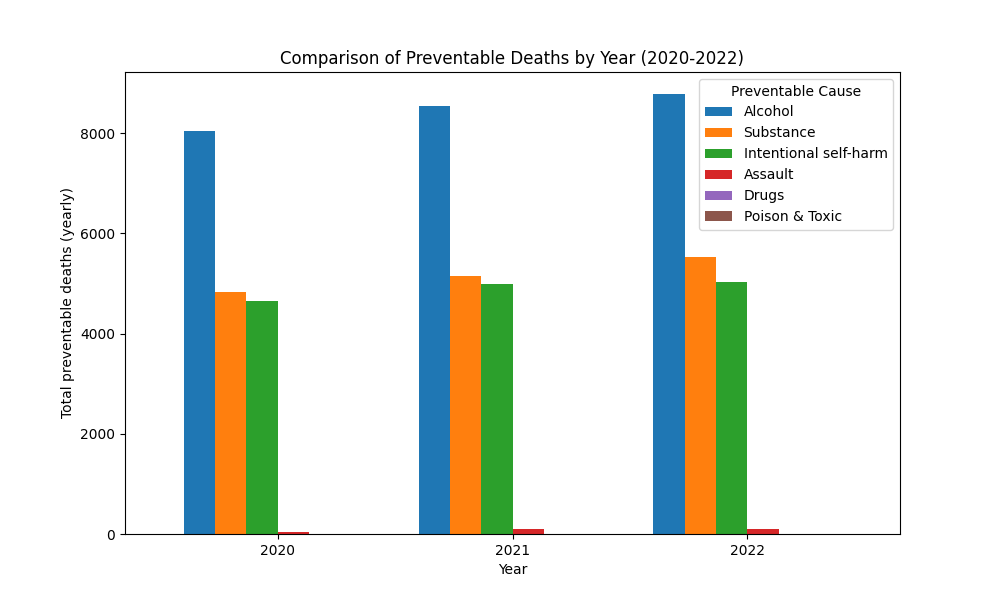










# Aggregating Data by County
## Identifying and Matching Unitary Subdivisions and Counties using pycountry


1. **Initial Data Retrieval**:  
   Started by using `pycountry` to fetch unitary subdivisions of the UK. 

2. **Satisfaction Check**:  
   Evaluated the matches found in the `df_grouped` DataFrame but was not satisfied with the number of matches.

3. **Alternative Approach**:  
   Decided to explore additional datasets to enhance matching and validation.

4. **Data Integration**:  
   Sought out supplementary data sources to improve the identification of unitary subdivisions and counties.

5. **Final Evaluation**:  
   Analyzed the new data for better coverage and accuracy in matching subdivisions and counties.




In [8]:
uk_subs = list(pycountry.subdivisions.get(country_code='GB'))
unitary_sub = [sub.name for sub in uk_subs if 'unitary' in sub.type.lower()]

print('No of Unitary Subdivisions:', len(unitary_sub))

matched_units = [unit for unit in unitary_sub if df_grouped['Area'].str.contains(unit, case=False, na=False, regex=False).any()]
print('No of Unitary Subdivisions matched with Areas:', len(matched_units))

counties_list = [
    'Bedfordshire', 'Berkshire', 'Birmingham', 'Bristol', 'Buckinghamshire',
    'Cambridgeshire', 'Cheshire', 'City of London', 'Cornwall', 'Cumbria',
    'Derbyshire', 'Devon', 'Dorset', 'Durham', 'East Riding of Yorkshire',
    'East Sussex', 'Essex', 'Gloucestershire', 'Greater Manchester',
    'Hampshire', 'Herefordshire', 'Hertfordshire', 'Humberside', 
    'Isle of Wight', 'Kent', 'Lancashire', 'Leicestershire', 'Lincolnshire',
    'Liverpool', 'London', 'Manchester', 'Merseyside', 'Middlesex',
    'Norfolk', 'North Yorkshire', 'Northumberland', 'Nottinghamshire',
    'Oxfordshire', 'Rutland', 'Shropshire', 'Somerset', 'South Yorkshire',
    'Staffordshire', 'Suffolk', 'Surrey', 'Sussex', 'Tyne and Wear',
    'West Midlands'
]

matches = [county for county in counties_list if df_grouped['Area'].str.contains(county, case=False, na=False, regex=False).any()]
print('No of Counties matched with Areas:', len(matches))

counties = [sub.name for sub in uk_subs if 'county' in sub.type.lower()]
print('No of Counties:', len(counties))

subs = list(set(sub.name for sub in uk_subs))
print('No of Unique Subdivisions:', len(subs))


No of Unitary Subdivisions: 80
No of Unitary Subdivisions matched with Areas: 61
No of Counties matched with Areas: 35
No of Counties: 25
No of Unique Subdivisions: 221


In [9]:
geo_ref = pd.read_excel('data/georef-united-kingdom.xlsx')

print(geo_ref.columns)

county_df = df_grouped.merge(geo_ref, left_on='Area', right_on='Official Name Local authority district', how='inner')

county_cols_drop = ['Year_y','Official Code Country', 
                    'Official Name Country','Official Code Region',
                    'Official Code County/Unitary district',
                    'Official Code Local authority district',
                    'Official Name Local authority district', 'Iso 3166-3 Area Code','Type']

county_df.drop(county_cols_drop, axis=1, inplace=True)

county_df.rename(columns={'Year_x': 'Year',
                  'Official Name Region' : 'Region',
                  'Official Name County/Unitary district' : 'County'}, inplace=True)

unmatched = df_grouped[~df_grouped['Area'].isin(county_df['Area'])]

print(f'There was {unmatched.shape[0]//3} area that was not matched.')

df_aggregated = county_df.groupby('County').agg({
    'All causes': 'sum',  
    'Alcohol': 'sum',
    'Assault' : 'sum',
    'Intentional self-harm' :'sum',
    'Poison & Toxic': 'sum',
    'Substance' :'sum',
    'Drugs' : 'sum'
}).reset_index()

print(df_aggregated.shape)
df_aggregated.head(2)

Index(['Geo Point', 'Geo Shape', 'Year', 'Official Code Country',
       'Official Name Country', 'Official Code Region', 'Official Name Region',
       'Official Code County/Unitary district',
       'Official Name County/Unitary district',
       'Official Code Local authority district',
       'Official Name Local authority district', 'Iso 3166-3 Area Code',
       'Type'],
      dtype='object')
There was 1 area that was not matched.
(173, 8)


,County,All causes,Alcohol,Assault,Intentional self-harm,Poison & Toxic,Substance,Drugs
0,Barking and Dagenham,4213.0,53.0,0.0,36.0,0.0,38.0,0.0
1,Barnet,8204.0,76.0,0.0,34.0,0.0,49.0,0.0


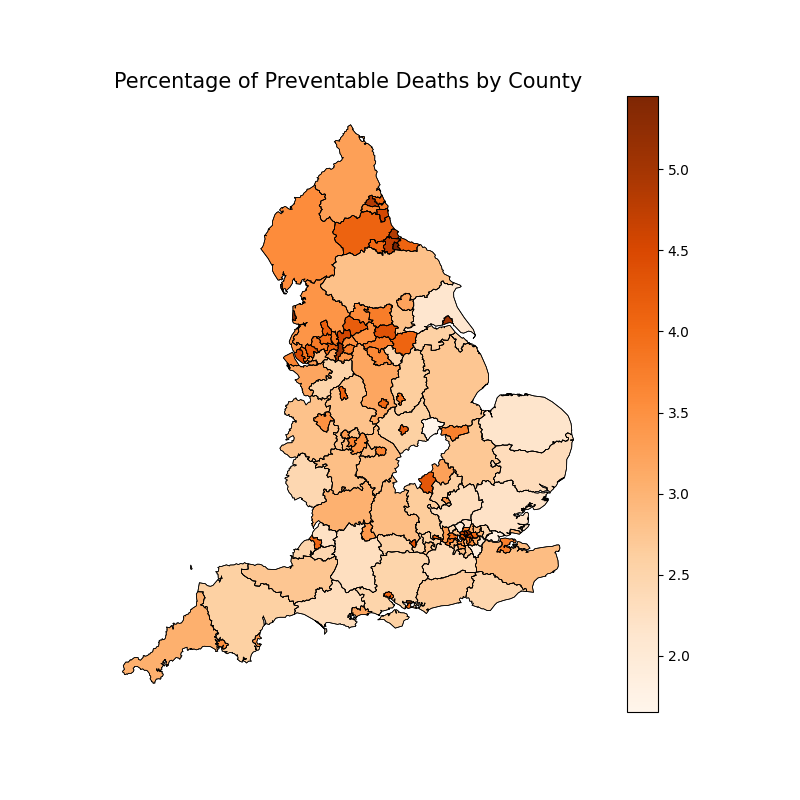
Clusters of high preventable death are seen in the Manchester/Merseyside Region, North East, West Midlands and Central London. This is visually contrasted to the East of England and the South West.

## Aggregating Death Data by Region

1. **Objective**:  
   Aggregate death data by region aimed to generate clear visual representations that highlight trends and disparities across regions.


2. **Data Grouping**:  
   Grouped the dataset by geographical regions to summarize total deaths and relevant categories.

  



In [10]:
df_region = county_df.groupby('Region').agg({
    'All causes': 'sum',  
    'Alcohol': 'sum',
    'Assault' : 'sum',
    'Intentional self-harm' :'sum',
    'Poison & Toxic': 'sum',
    'Substance' :'sum',
    'Drugs' : 'sum'
}).reset_index()

print(df_region.shape)
df_region.head(2)

(10, 8)


,Region,All causes,Alcohol,Assault,Intentional self-harm,Poison & Toxic,Substance,Drugs
0,East Midlands,152400.0,2200.0,46.0,1155.0,0.0,1202.0,0.0
1,East of England,189408.0,2091.0,0.0,1325.0,0.0,1169.0,0.0


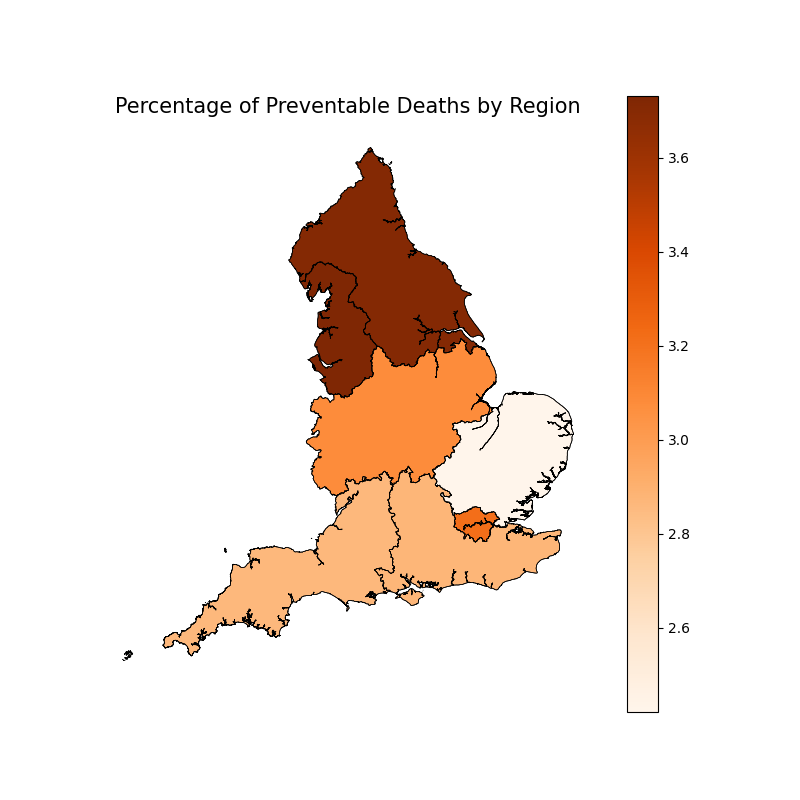
A clear North/South Divide can be seen here

# Exploratory Data Analysis on Mortality Trends

**DataFrame Information and Descriptive Statistics**:
   - The `.info()`method provides a concise summary of the DataFrame  and `.describe()`method generates descriptive statistics for numerical columns

## Mortality Data Summary by Year

### 2020
- Total: 607,099 | Self-Harm: 4,646 | Alcohol: 8,040
- Most Deaths: Birmingham - 10,359 | Self-Harm: Leeds - 71 | Alcohol: Birmingham - 143

### 2021
- Total: 585,484 | Self-Harm: 4,990 | Alcohol: 8,541
- Most Deaths: Birmingham - 9,922 | Self-Harm: County Durham - 84 | Alcohol: Birmingham - 162

### 2022
- Total: 576,027 | Self-Harm: 5,039 | Alcohol: 8,781
- Most Deaths: Birmingham - 9,106 | Self-Harm: Birmingham - 78 | Alcohol: Birmingham - 161



This analysis provides a comprehensive overview of mortality trends, highlighting the impacts of self-harm and alcohol-related deaths across different regions and years.



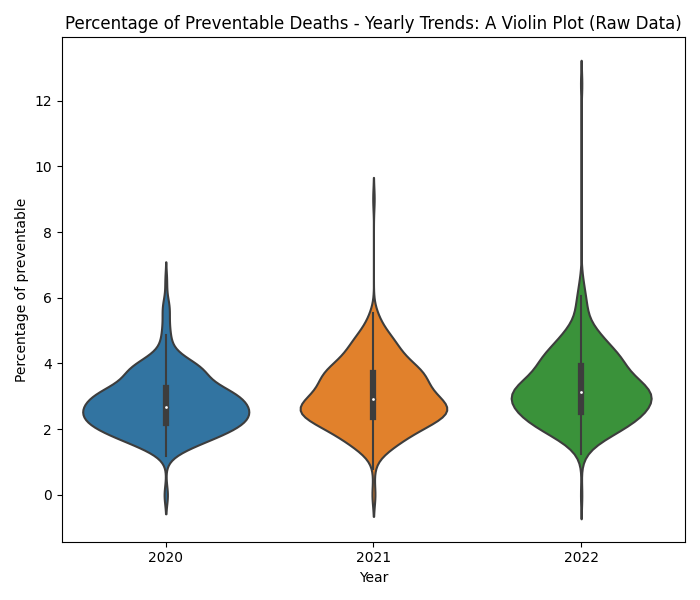

## Area

In [11]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Area                   994 non-null    object 
 1   Year                   994 non-null    int64  
 2   All causes             993 non-null    float64
 3   Alcohol                994 non-null    float64
 4   Assault                994 non-null    float64
 5   Poison & Toxic         994 non-null    float64
 6   Drugs                  994 non-null    float64
 7   Substance              994 non-null    float64
 8   Intentional self-harm  994 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 70.0+ KB


In [12]:
df_grouped.describe()

,Year,All causes,Alcohol,Assault,Poison & Toxic,Drugs,Substance,Intentional self-harm
count,994.000000,993.000000,994.000000,994.000000,994.0,994.0,994.000000,994.000000
mean,2020.998994,1781.077543,25.515091,0.230382,0.0,0.0,15.590543,14.763581
std,0.817112,1137.787890,19.689541,1.060241,0.0,0.0,15.404527,11.287216
min,2020.000000,16.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,2020.000000,1126.000000,13.000000,0.000000,0.0,0.0,5.000000,8.000000
50%,2021.000000,1444.000000,20.000000,0.000000,0.0,0.0,11.000000,12.000000
75%,2022.000000,2044.000000,31.000000,0.000000,0.0,0.0,20.000000,17.000000
max,2022.000000,10359.000000,162.000000,6.000000,0.0,0.0,116.000000,84.000000


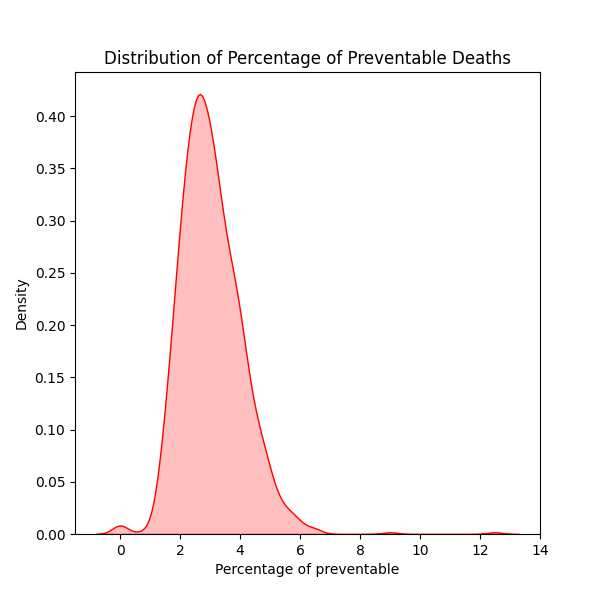

In [13]:
years = [2020, 2021, 2022]
categories = ['All causes', 'Intentional self-harm', 'Alcohol']
totals = {category: {} for category in categories}


for year in years:
    for category in categories:
        totals[category][year] = df_grouped[df_grouped["Year"] == year][category].sum()

for year in years:
    print(f"In {year}, there were {int(totals['All causes'][year])} deaths, "
          f"of which self-harm accounted for {int(totals['Intentional self-harm'][year])} "
          f"deaths and alcohol accounted for {int(totals['Alcohol'][year])} deaths.")

for year in years:
    max_area_all = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["All causes"].idxmax(), "Area"]
    max_deaths_all = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["All causes"].idxmax(), "All causes"]
    print(f'\nIn {year}, {max_area_all} was the area with the most deaths: {int(max_deaths_all)}.')

    max_area_sh = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["Intentional self-harm"].idxmax(), "Area"]
    max_deaths_sh = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["Intentional self-harm"].idxmax(), "Intentional self-harm"]
    print(f"In {year}, {max_area_sh} was the area with the most deaths due to intentional self-harm: {int(max_deaths_sh)}.")

    max_area_alc = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["Alcohol"].idxmax(), "Area"]
    max_deaths_alc = df_grouped.loc[df_grouped[df_grouped["Year"] == year]["Alcohol"].idxmax(), "Alcohol"]
    print(f"In {year}, {max_area_alc} was the area with the most deaths due to alcohol: {int(max_deaths_alc)}.")


In 2020, there were 607099 deaths, of which self-harm accounted for 4646 deaths and alcohol accounted for 8040 deaths.
In 2021, there were 585484 deaths, of which self-harm accounted for 4990 deaths and alcohol accounted for 8541 deaths.
In 2022, there were 576027 deaths, of which self-harm accounted for 5039 deaths and alcohol accounted for 8781 deaths.

In 2020, Birmingham was the area with the most deaths: 10359.
In 2020, Leeds was the area with the most deaths due to intentional self-harm: 71.
In 2020, Birmingham was the area with the most deaths due to alcohol: 143.

In 2021, Birmingham was the area with the most deaths: 9922.
In 2021, County Durham was the area with the most deaths due to intentional self-harm: 84.
In 2021, Birmingham was the area with the most deaths due to alcohol: 162.

In 2022, Birmingham was the area with the most deaths: 9106.
In 2022, Birmingham was the area with the most deaths due to intentional self-harm: 78.
In 2022, Birmingham was the area with the mo

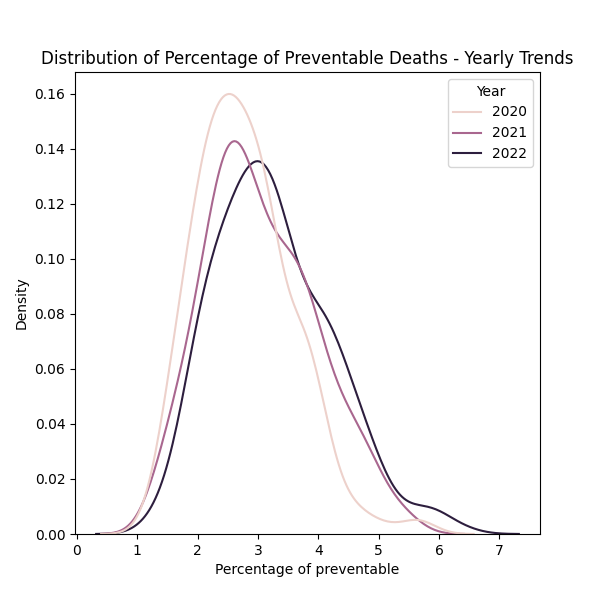
This plot shows the distribution shifting to the right each year, showing increasing average of preventable deaths, with a wider degree of varience 

## County

In [14]:
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   County                 173 non-null    object 
 1   All causes             173 non-null    float64
 2   Alcohol                173 non-null    float64
 3   Assault                173 non-null    float64
 4   Intentional self-harm  173 non-null    float64
 5   Poison & Toxic         173 non-null    float64
 6   Substance              173 non-null    float64
 7   Drugs                  173 non-null    float64
dtypes: float64(7), object(1)
memory usage: 10.9+ KB


In [15]:
df_aggregated.describe()

,All causes,Alcohol,Assault,Intentional self-harm,Poison & Toxic,Substance,Drugs
count,173.000000,173.00000,173.000000,173.000000,173.0,173.000000,173.0
mean,10174.982659,145.83815,1.323699,84.537572,0.0,89.127168,0.0
std,8913.295660,113.21002,2.809735,73.167497,0.0,68.384226,0.0
min,64.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0
25%,4945.000000,74.00000,0.000000,38.000000,0.0,41.000000,0.0
50%,6962.000000,109.00000,0.000000,56.000000,0.0,67.000000,0.0
75%,11383.000000,175.00000,0.000000,97.000000,0.0,119.000000,0.0
max,50143.000000,700.00000,12.000000,457.000000,0.0,396.000000,0.0


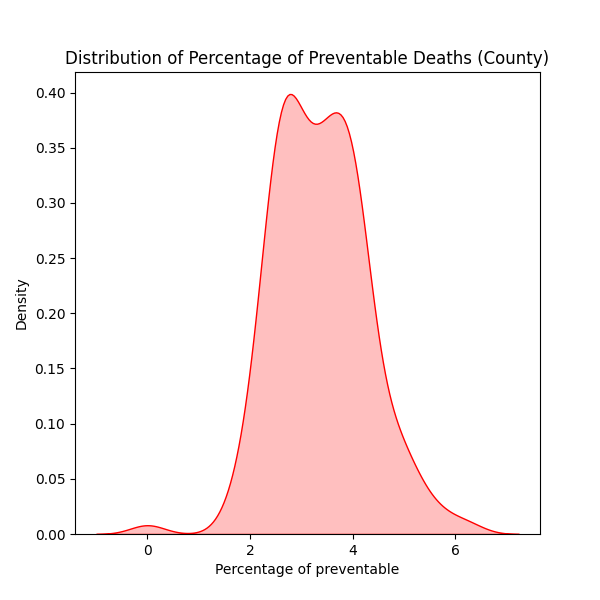

## Regional

In [16]:
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Region                 10 non-null     object 
 1   All causes             10 non-null     float64
 2   Alcohol                10 non-null     float64
 3   Assault                10 non-null     float64
 4   Intentional self-harm  10 non-null     float64
 5   Poison & Toxic         10 non-null     float64
 6   Substance              10 non-null     float64
 7   Drugs                  10 non-null     float64
dtypes: float64(7), object(1)
memory usage: 772.0+ bytes


In [17]:
df_region.describe()

,All causes,Alcohol,Assault,Intentional self-harm,Poison & Toxic,Substance,Drugs
count,10.000000,10.000000,10.000000,10.0000,10.0,10.000000,10.0
mean,176027.200000,2523.000000,22.900000,1462.5000,0.0,1541.900000,0.0
std,54434.775445,820.055825,14.783249,483.6225,0.0,518.164378,0.0
min,92670.000000,1502.000000,0.000000,794.0000,0.0,817.000000,0.0
25%,156461.750000,2117.500000,11.250000,1197.5000,0.0,1226.500000,0.0
50%,179394.000000,2329.500000,22.500000,1441.0000,0.0,1427.000000,0.0
75%,188569.500000,2768.000000,34.250000,1614.2500,0.0,1826.000000,0.0
max,269840.000000,4223.000000,46.000000,2333.0000,0.0,2675.000000,0.0


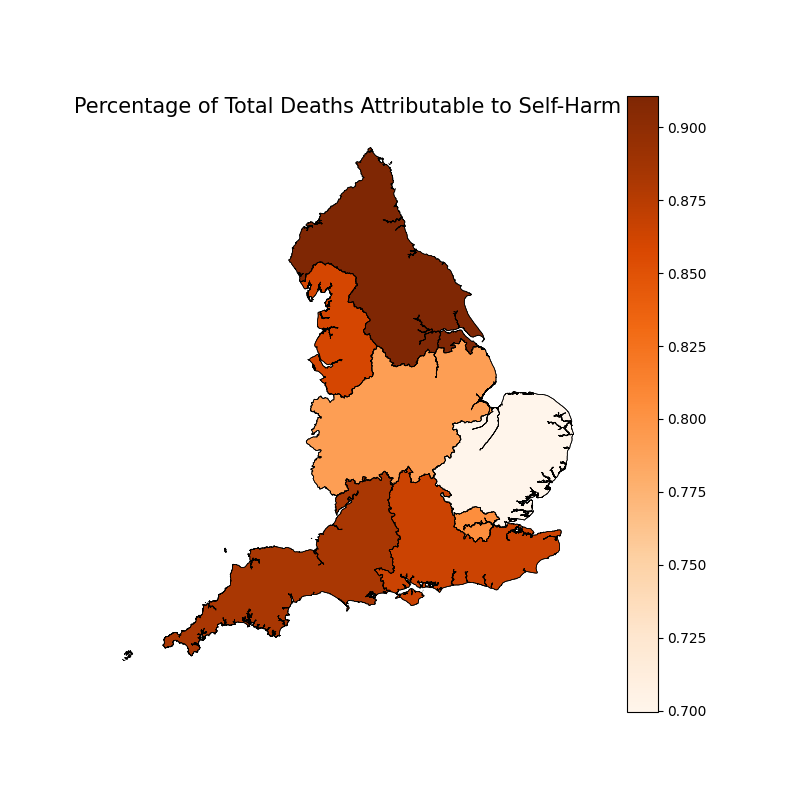
North West Region showing highest percentage, a more even spread around regions, excluding the East which shows a comparatively  low percentage of deaths due to self-harm

## Merging and Calculating Deprivation Ranks (Area)

1. **Load Deprivation Ranks**:
   - The deprivation ranks are read from an Excel file and set with 'Local Authority District name (2019)' as the index.
2. **Calculate Average Deprivation Rank**:
   - An 'Average Rank' is calculated by summing the individual deprivation ranks (Health, Education, Employment, Income, Crime, Living Environment) and dividing by 6 to get the average.

This process enhances the DataFrame by integrating deprivation rank data, allowing for comprehensive analysis of socio-economic factors across different areas.


In [18]:
local_rank_df = pd.read_excel('data/Local Authority deprivation ranks.xlsx') 
local_rank_df = local_rank_df.set_index('Local Authority District name (2019)')

df_fullrank = df_grouped.copy()
df_fullrank = df_grouped.merge(local_rank_df, how='inner', left_on='Area', right_on='Local Authority District name (2019)')
df_fullrank.head(2)

df_fullrank.rename(columns={'Health Deprivation and Disability - Rank of average rank ' : 'Health Deprivation Rank',
                            'Education, Skills and Training - Rank of average rank ' : 'Education Deprivation Rank',
                            'Employment - Rank of average rank ' : 'Employment Deprivation Rank',
                            'Income - Rank of average rank ' : 'Income Deprivation Rank',
                            'Crime - Rank of average rank ' : 'Crime Rank',
                            'Living Environment - Rank of average rank ' : 'Living Environment Deprivation Rank'}, inplace=True)

df_fullrank['Average Rank'] = (df_fullrank['Health Deprivation Rank'] +  df_fullrank['Education Deprivation Rank'] + \
                             df_fullrank['Employment Deprivation Rank'] +  df_fullrank['Income Deprivation Rank'] + \
                             df_fullrank['Crime Rank'] + df_fullrank['Living Environment Deprivation Rank']) // 6
print(df_fullrank.shape)
df_fullrank.head(2)

(918, 16)


,Area,Year,All causes,Alcohol,Assault,Poison & Toxic,Drugs,Substance,Intentional self-harm,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank
0,Darlington,2020,1349.0,23.0,0.0,0.0,0.0,15.0,9.0,61,114,65,94,30,300,110
1,Darlington,2021,1237.0,24.0,0.0,0.0,0.0,9.0,24.0,61,114,65,94,30,300,110


## Merging and Calculating County Deprivation Ranks



In [19]:
county_df_rank = pd.read_excel('data/county deprivation ranks.xlsx')
county_df_rank = county_df_rank.set_index('Upper Tier Local Authority District name (2019)')

df_county_rank = df_aggregated.copy()
df_county_rank = df_county_rank.merge(county_df_rank, how='inner', left_on='County', right_on='Upper Tier Local Authority District name (2019)')
df_county_rank.rename(columns={'Health Deprivation and Disability - Rank of average rank ' : 'Health Deprivation Rank',
                            'Education, Skills and Training - Rank of average rank ' : 'Education Deprivation Rank',
                            'Employment - Rank of average rank ' : 'Employment Deprivation Rank',
                            'Income - Rank of average rank ' : 'Income Deprivation Rank',
                            'Crime - Rank of average rank ' : 'Crime Rank',
                            'Living Environment - Rank of average rank ' : 'Living Environment Deprivation Rank'}, inplace=True)

df_county_rank['Average Rank'] = (df_county_rank['Health Deprivation Rank'] +  df_county_rank['Education Deprivation Rank'] + \
                                  df_county_rank['Employment Deprivation Rank'] +  df_county_rank['Income Deprivation Rank'] + \
                                  df_county_rank['Crime Rank'] + df_county_rank['Living Environment Deprivation Rank']) // 6
print(df_county_rank.shape)
df_county_rank.head(2)



(150, 15)


,County,All causes,Alcohol,Assault,Intentional self-harm,Poison & Toxic,Substance,Drugs,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank
0,Barking and Dagenham,4213.0,53.0,0.0,36.0,0.0,38.0,0.0,61,21,31,4,18,33,28
1,Barnet,8204.0,76.0,0.0,34.0,0.0,49.0,0.0,146,145,119,91,82,50,105


![Indicies%20of%20Deprivation%20by%20County%20%28Average%20Rank%29%20(3).png](attachment:Indicies%20of%20Deprivation%20by%20County%20%28Average%20Rank%29%20(3).png)
Clusters of high deprivation are also seen in the Manchester/Mersyside Region, North East, West Midlands and Central London. This is visually contasted to the East of Enland and the South West.
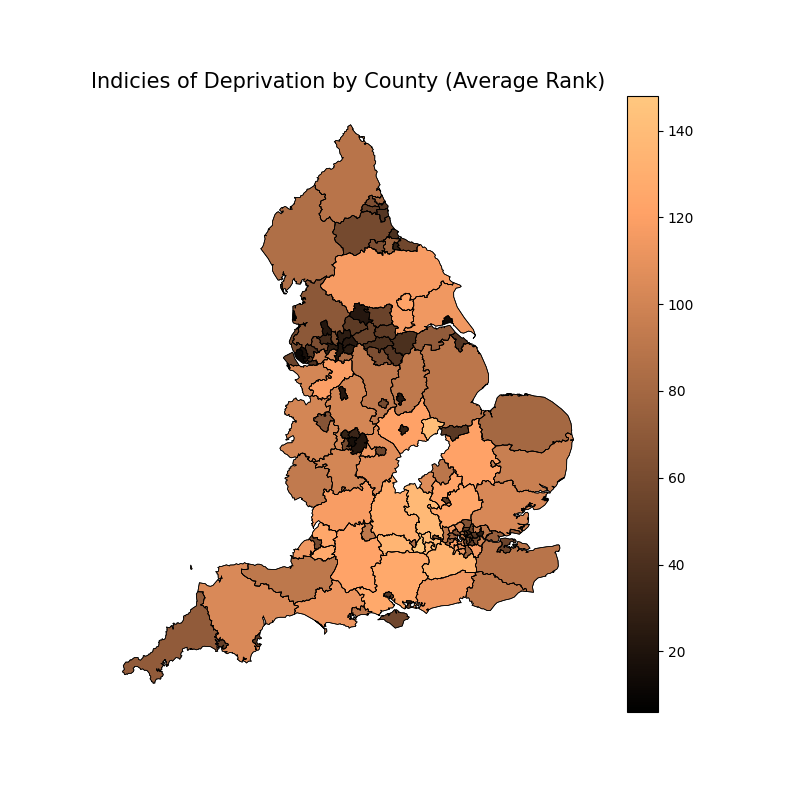

## Calculating Percentages of Causes of Death (Area)

1. **Create a Copy of the DataFrame**:
   - A new DataFrame, `df_percent`, is created as a copy of `df_fullrank` to maintain the original data while performing calculations.

2. **Calculate Percentage Columns and Droping Original Columns**:
   - New columns are added to `df_percent` to represent the percentage of specific causes of death relative to 'All causes':
   - Additionally, a new column, **Percentage of Preventable**, is calculated by summing the relevant causes and dividing by 'All causes'.

This process efficiently transforms raw counts of causes of death into meaningful percentages, aiding in the analysis of preventable deaths.


In [20]:
df_percent = df_fullrank.copy()
df_percent['Assault %'] = df_percent['Assault'] / df_percent['All causes'] * 100
df_percent['Self-harm %'] = df_percent['Intentional self-harm'] / df_percent['All causes'] * 100
df_percent['Alcohol %'] = df_percent['Alcohol'] / df_percent['All causes'] * 100
df_percent['Poison & Toxic %'] = df_percent['Poison & Toxic'] / df_percent['All causes'] * 100
df_percent['Drugs %'] = df_percent['Drugs'] / df_percent['All causes'] * 100
df_percent['Substance %'] = df_percent['Substance'] / df_percent['All causes'] * 100
df_percent['Percentage of preventable'] = (df_percent['Alcohol'] + df_percent['Drugs'] + df_percent['Poison & Toxic'] \
                                           + df_percent['Substance'] + df_percent['Intentional self-harm']+ df_percent['Assault'])/ df_percent['All causes'] * 100
 
    
percent_cols_drop = ['Assault', 'Intentional self-harm', 'Alcohol', 'Poison & Toxic', 'Drugs', 'Substance']

df_percent = df_percent.drop(columns=percent_cols_drop)

print(df_percent.shape)
df_percent.head(2)

(918, 17)


,Area,Year,All causes,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable
0,Darlington,2020,1349.0,61,114,65,94,30,300,110,0.0,0.667161,1.704967,0.0,0.0,1.111935,3.484062
1,Darlington,2021,1237.0,61,114,65,94,30,300,110,0.0,1.940178,1.940178,0.0,0.0,0.727567,4.607922


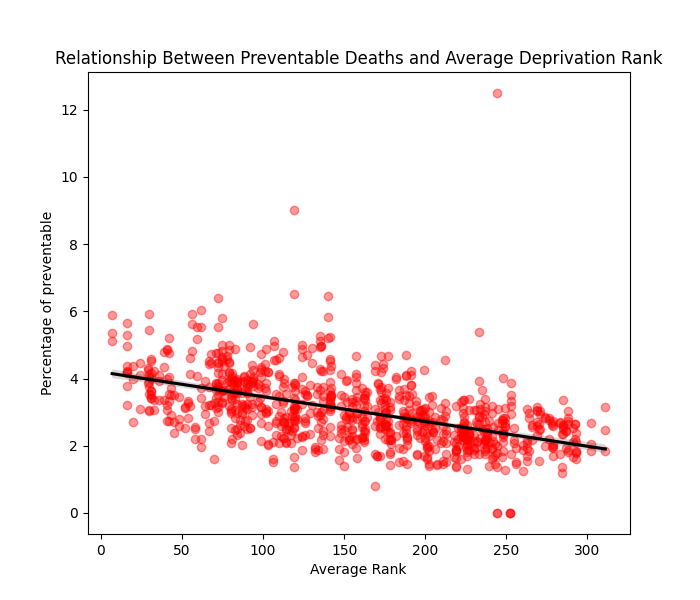
Plot shows general downwards trend, as deprivation rank gets larger (area being less deprived), preventable deaths decrease as well.

## Calculating Percentages of Causes of Death by County


In [21]:
df_county_percent = df_county_rank.copy()
df_county_percent['Assault %'] = df_county_percent['Assault'] / df_county_percent['All causes'] * 100
df_county_percent['Self-harm %'] = df_county_percent['Intentional self-harm'] / df_county_percent['All causes'] * 100
df_county_percent['Alcohol %'] = df_county_percent['Alcohol'] / df_county_percent['All causes'] * 100
df_county_percent['Poison & Toxic %'] = df_county_percent['Poison & Toxic'] / df_county_percent['All causes'] * 100
df_county_percent['Drugs %'] = df_county_percent['Drugs'] / df_county_percent['All causes'] * 100
df_county_percent['Substance %'] = df_county_percent['Substance'] / df_county_percent['All causes'] * 100
df_county_percent['Percentage of preventable'] = (df_county_percent['Alcohol'] + df_county_percent['Drugs'] \
                                                 + df_county_percent['Poison & Toxic'] + df_county_percent['Substance'] \
                                                + df_county_percent['Intentional self-harm']+ df_county_percent['Assault'])/ df_county_percent['All causes'] * 100
 
    
percent_cols_drop2 = ['Assault', 'Intentional self-harm', 'Alcohol', 'Poison & Toxic', 'Drugs', 'Substance']

df_county_percent = df_county_percent.drop(columns=percent_cols_drop2)
print(df_county_percent.shape)
df_county_percent.head(2)



(150, 16)


,County,All causes,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable
0,Barking and Dagenham,4213.0,61,21,31,4,18,33,28,0.0,0.854498,1.258011,0.0,0.0,0.90197,3.014479
1,Barnet,8204.0,146,145,119,91,82,50,105,0.0,0.414432,0.926377,0.0,0.0,0.59727,1.938079


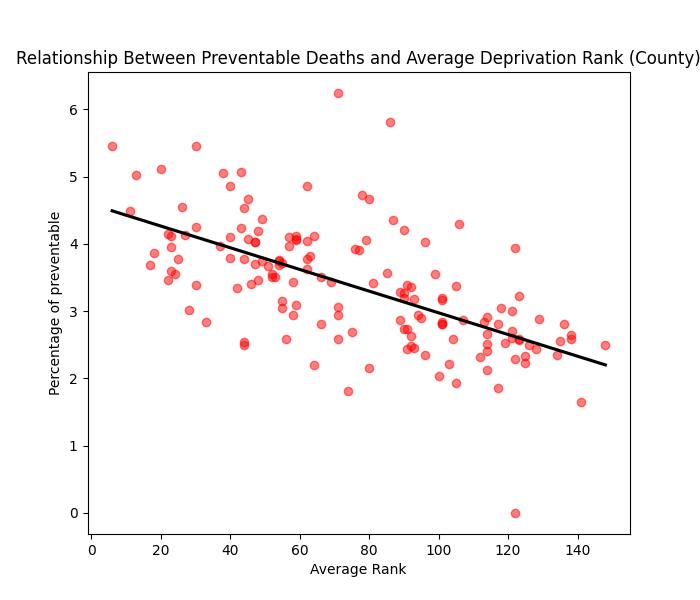
This plot shows a stronger downwards trend, as deprivation rank gets larger (area being less deprived), preventable deaths decrease as well.

## Calculating Percentages of Causes of Death by Region


In [22]:
df_region_percent = df_region.copy()
df_region_percent['Assault %'] = df_region_percent['Assault'] / df_region_percent['All causes'] * 100
df_region_percent['Self-harm %'] = df_region_percent['Intentional self-harm'] / df_region_percent['All causes'] * 100
df_region_percent['Alcohol %'] = df_region_percent['Alcohol'] / df_region_percent['All causes'] * 100
df_region_percent['Poison & Toxic %'] = df_region_percent['Poison & Toxic'] / df_region_percent['All causes'] * 100
df_region_percent['Drugs %'] = df_region_percent['Drugs'] / df_region_percent['All causes'] * 100
df_region_percent['Substance %'] = df_region_percent['Substance'] / df_region_percent['All causes'] * 100
df_region_percent['Percentage of preventable'] = (df_region_percent['Alcohol'] + df_region_percent['Drugs'] \
                                                 + df_region_percent['Poison & Toxic'] + df_region_percent['Substance'] \
                                                + df_region_percent['Intentional self-harm']+ df_region_percent['Assault'])/ df_region_percent['All causes'] * 100
 
    
percent_cols_drop3 = ['Assault', 'Intentional self-harm', 'Alcohol', 'Poison & Toxic', 'Drugs', 'Substance']

df_region_percent = df_region_percent.drop(columns=percent_cols_drop2)
print(df_region_percent.shape)
df_region_percent.sort_values(by='Percentage of preventable', ascending=False, inplace=True)
df_region_percent.head(2)

(10, 9)


,Region,All causes,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable
3,North East,92670.0,0.010791,0.934499,1.846336,0.0,0.0,1.402827,4.194453
4,North West,241575.0,0.016558,0.859774,1.748111,0.0,0.0,1.107317,3.731760


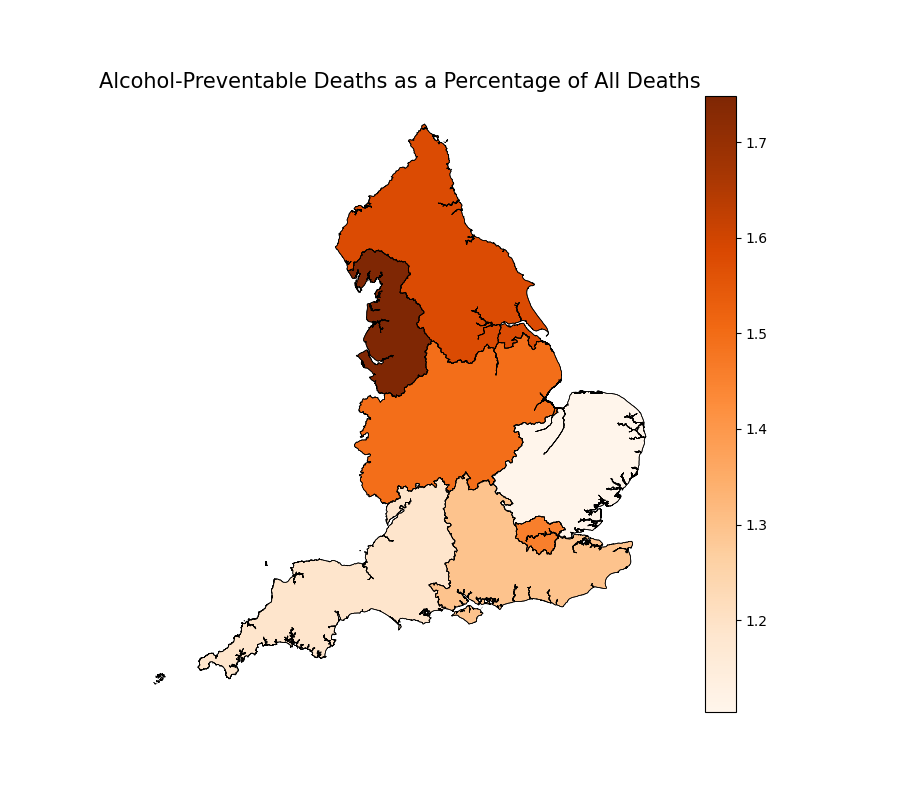
North West Region showing highest percentage, North East Region showing second highest percentage

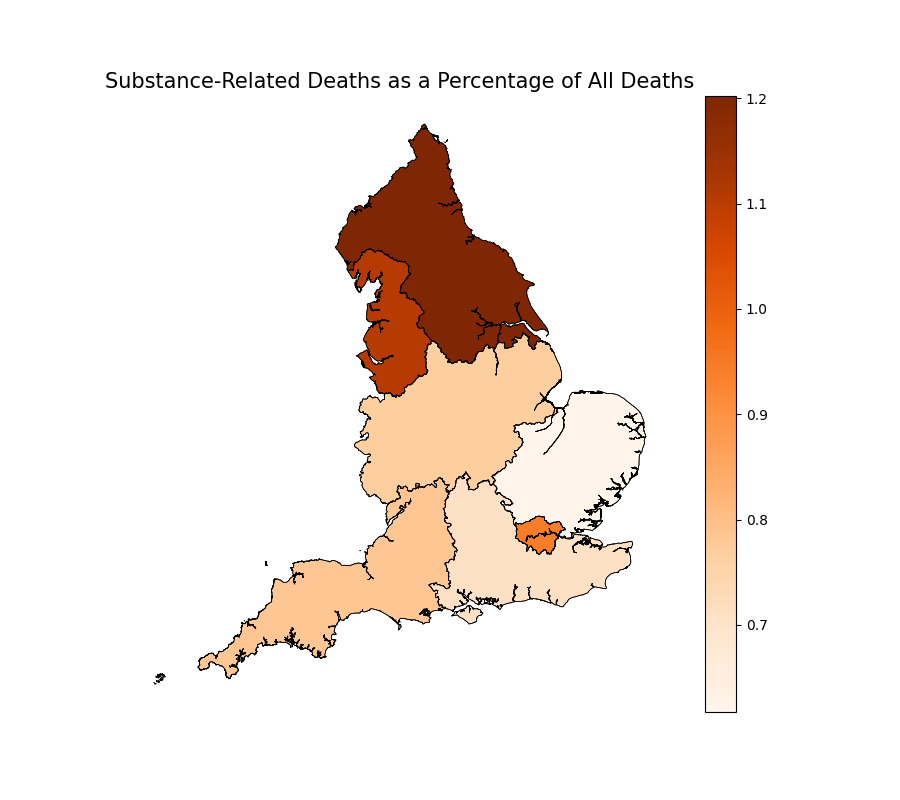
North East Region  showing highest percentage, North West Region showing second highest percentage

## Deprivation Categorisation & Assigning Colors to Deprivation Categories

This code categorizes average deprivation ranks:

1. **Categorization Function**: 
   - `dep_cat()` classifies ranks as 'High', 'Medium', or 'Low'.

2. **Count Categories**: 
   - Outputs counts of each category to assess deprivation distribution.

This method provides a clear understanding of deprivation levels in the datasets, and returning `value_counts()` ensures there is a decent distribution between catagories. Assigning specific colors for each rank, facilitates clearer data visualization in Bokeh.


In [23]:
def dep_cat(rank):
    if rank <= 100:
        return 'High'
    elif rank <=200:
        return 'Medium'
    else:
        return 'Low'
df_percent['Average Rank'] = pd.to_numeric(df_percent['Average Rank'], errors='coerce')

df_percent['Average Rank Category'] = df_percent['Average Rank'].apply(dep_cat)

df_percent['Average Rank Category'].value_counts()

Average Rank Category
Medium    378
Low       288
High      252
Name: count, dtype: int64

In [24]:
def dep_cat(rank):
    if rank <= 50:
        return 'High'
    elif rank <=100:
        return 'Medium'
    else:
        return 'Low'
df_county_percent['Average Rank'] = pd.to_numeric(df_county_percent['Average Rank'], errors='coerce')

df_county_percent['Average Rank Category'] = df_county_percent['Average Rank'].apply(dep_cat)

df_county_percent['Average Rank Category'].value_counts()

Average Rank Category
Medium    65
Low       43
High      42
Name: count, dtype: int64

In [25]:
category_colors = {'High':'#CE1141', 'Medium': 'orange', 'Low': 'blue'}
df_percent['category_color'] = [category_colors[x] for x in df_percent['Average Rank Category']]
df_county_percent['category_color'] = [category_colors[x] for x in df_county_percent['Average Rank Category']]

## Raw district data 

/kas/python_stacks/python_311_data_science/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


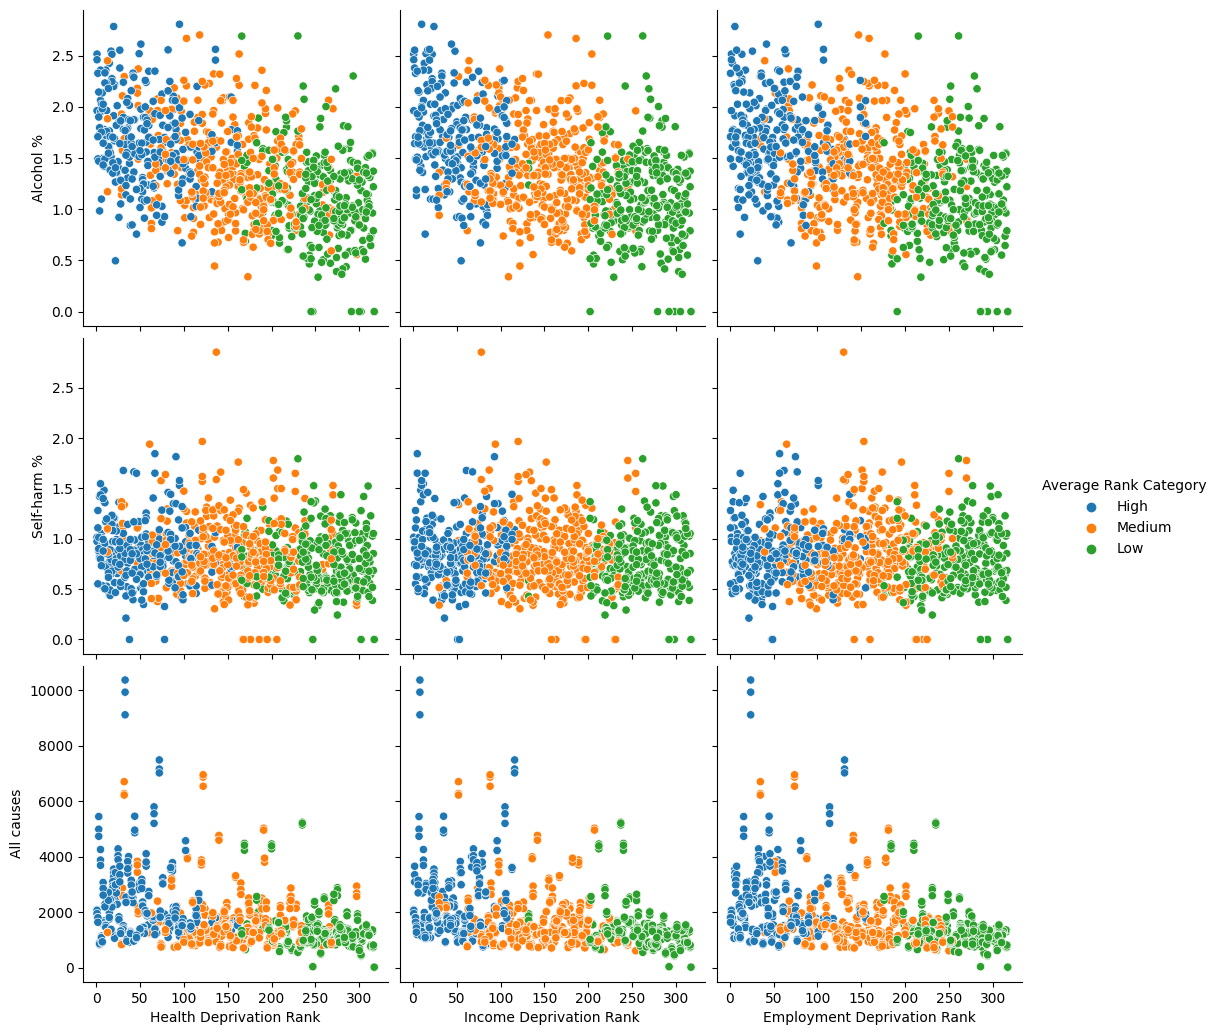

In [26]:
sns.pairplot(y_vars=['Alcohol %', 'Self-harm %', 'All causes'],
     x_vars=['Health Deprivation Rank', 'Income Deprivation Rank', 'Employment Deprivation Rank'],
    height=3.5,
    data=df_percent,
    hue='Average Rank Category',
    hue_order=('High', 'Medium', 'Low')
            )
plt.show()

## Raw County data

/kas/python_stacks/python_311_data_science/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


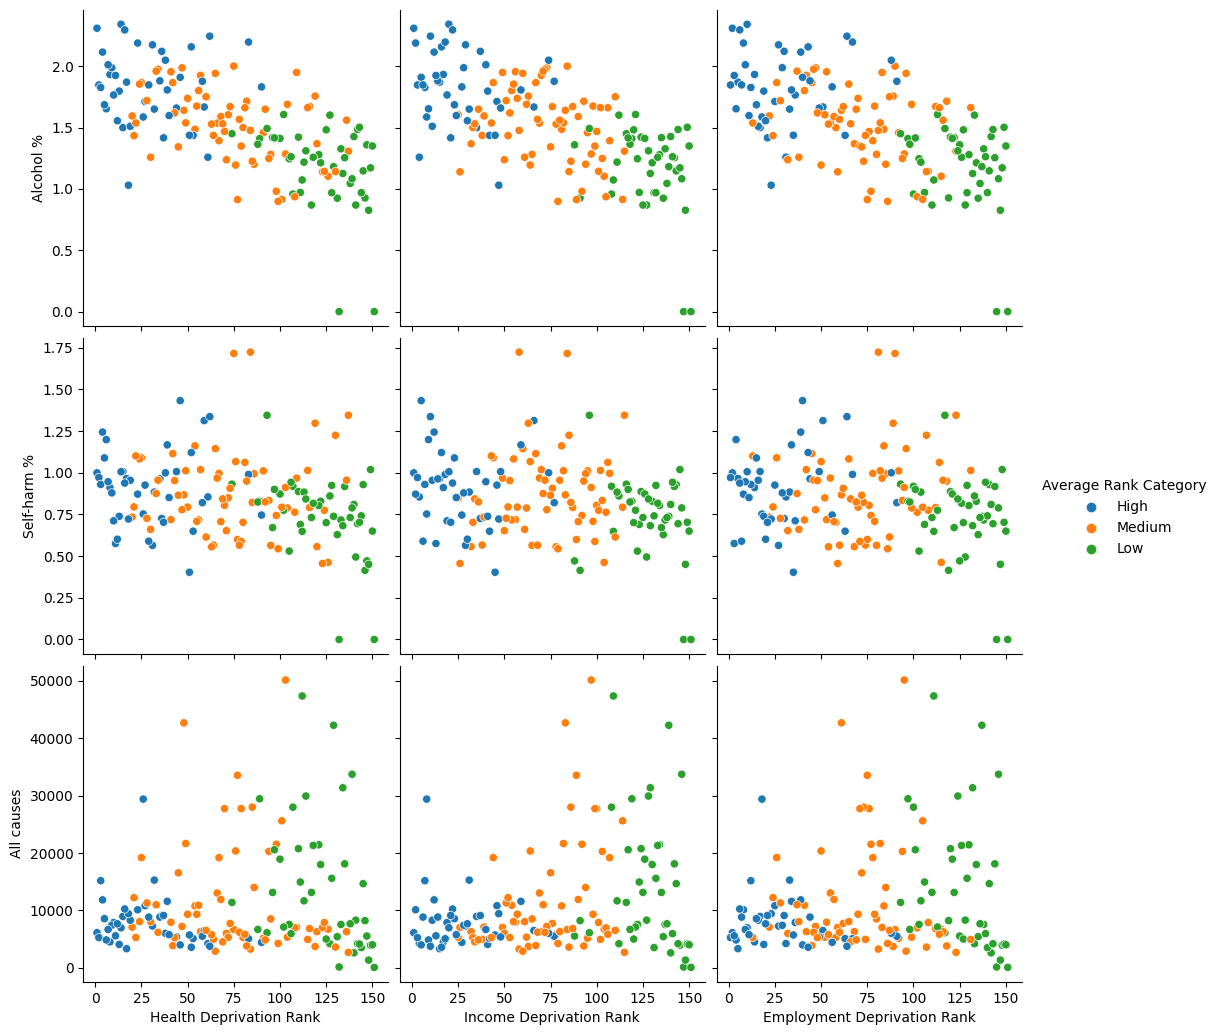

In [27]:
sns.pairplot(y_vars=['Alcohol %', 'Self-harm %', 'All causes'],
     x_vars=['Health Deprivation Rank', 'Income Deprivation Rank', 'Employment Deprivation Rank'],
    height=3.5,
    data=df_county_percent,
    hue='Average Rank Category',
    hue_order=('High', 'Medium', 'Low')
)
plt.show()

## Correlation Analysis with Outlier Consideration

1. **Pearson Correlation**:
   - The Pearson correlation coefficient between 'Average Rank' and 'Percentage of Preventable' quantifies the linear relationship between the two variables.

2. **Spearman Correlation**:
   - The Spearman rank correlation assesses the monotonic relationship, providing insights into how well the data can be ranked.

3. **Outlier Impact**:
   - An interactive Bokeh plot has been developed to visualize these correlations while highlighting outliers. By removing these outliers, the analysis can offer a clearer view of the underlying relationships.

4. **Improving Statistical Correlation**:
   - The Bokeh visualization allows for interactive exploration of the data, helping to identify and manage outliers effectively. This can lead to improved statistical correlation results, offering more reliable insights into the relationship between 'Average Rank' and 'Percentage of Preventable'.

This approach integrates statistical analysis with interactive visualization, enhancing the understanding of data relationships.


### Main Dataset

In [28]:
scipy.stats.pearsonr(df_percent['Average Rank'],df_percent['Percentage of preventable'])[0]

-0.5180015846115191

In [29]:
scipy.stats.spearmanr(df_percent['Average Rank'],df_percent['Percentage of preventable'])[0]

-0.5782118340707877

### County Dataset

In [30]:
scipy.stats.spearmanr(df_county_percent['Average Rank'],df_county_percent['Percentage of preventable'])[0]

-0.6590676786132401

In [31]:
scipy.stats.pearsonr(df_county_percent['Average Rank'],df_county_percent['Percentage of preventable'])[0]

-0.6181985330976881

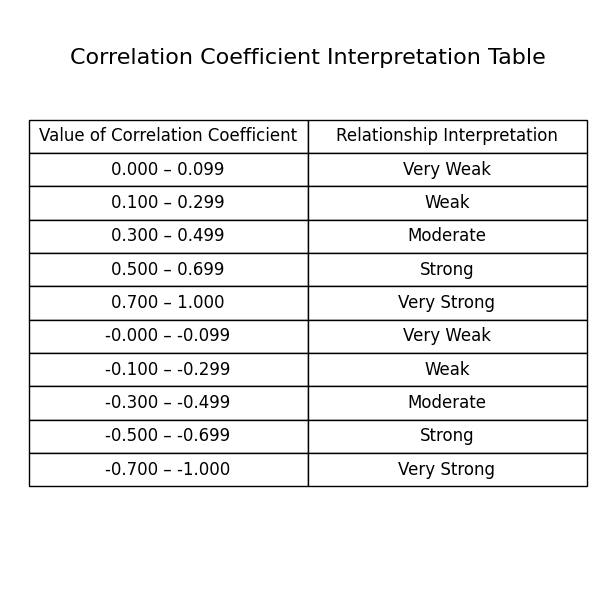

## Interactive Bokeh Visualization for Outliers

1. **Purpose**:
   - An interactive Bokeh plot has been created to visually highlight outliers in the dataset.

2. **Features**:
   - Outliers are clearly marked for easy identification.
   - Users of the notebook can interact with the plot to explore different aspects of the data.

3. **Benefits**:
   - This visualization aids in understanding the distribution and variability within the data.
   - It enhances data exploration and analysis by allowing users to focus on significant deviations.

This interactive tool provides an intuitive way to analyze outliers, supporting deeper insights into the dataset and improving statistical analysis later on.


### Main Dataset

In [32]:
data = ColumnDataSource(df_percent)

p2 = figure(width=650,
            height=650,
           tooltips=[('Location', '@Area')])

p2.scatter(x='Average Rank', 
           y='Percentage of preventable', 
           source=data, 
           marker='square', 
           size=8, 
           alpha=0.8,
           fill_color='category_color', 
           legend_group='Average Rank Category')
p2.title.text = "Deprivation vs Preventable Deaths"
p2.title.text_font_size = '20pt'
p2.xaxis.axis_label = 'Average Deprivation Rank'
p2.yaxis.axis_label = 'Percentage of Preventable Deaths '
p2.xaxis.axis_label_text_font_size ='15pt'
p2.yaxis.axis_label_text_font_size ='15pt'

show(p2);



## Data Cleaning by Dropping Specific Areas


This process prepares the dataset for further analysis by removing areas that may skew the results.


In [33]:
area_drop_list=['Hammersmith and Fulham', 'Brighton and Hove', "King's Lynn and West Norfolk", \
                'Isles of Scilly', 'City of London', 'Castle Point', 'North Norfolk', 'Thurrock', 'Tendring', \
                'Woking', 'Cheltenham', 'Milton Keynes', 'Camden', 'Stockton-on-Tees', 'Melton']

df_clean_percent= df_percent.copy()
df_clean_percent.set_index('Area', inplace=True)
df_clean_percent= df_clean_percent.drop(area_drop_list, axis=0)

print(df_clean_percent.shape)
df_clean_percent.head(2)

(873, 18)


,Year,All causes,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable,Average Rank Category,category_color
Area,,,,,,,,,,,,,,,,,,
Darlington,2020,1349.0,61,114,65,94,30,300,110,0.0,0.667161,1.704967,0.0,0.0,1.111935,3.484062,Medium,orange
Darlington,2021,1237.0,61,114,65,94,30,300,110,0.0,1.940178,1.940178,0.0,0.0,0.727567,4.607922,Medium,orange


In [34]:
data = ColumnDataSource(df_clean_percent)

p3 = figure(width=650,
            height=650,
           tooltips=[('Location', '@Area')])

p3.scatter(x='Average Rank', 
           y='Percentage of preventable', 
           source=data, 
           marker='square', 
           size=8, 
           alpha=0.8,
           fill_color='category_color', 
           legend_group='Average Rank Category')
p3.title.text = "Deprivation vs Preventable Deaths"
p3.xaxis.axis_label = 'Average Deprivation Rank'
p3.yaxis.axis_label = 'Percentage of Preventable Deaths ' 
p3.title.text_font_size = '20pt'
p3.xaxis.axis_label_text_font_size ='15pt'
p3.yaxis.axis_label_text_font_size ='15pt'
p3.y_range.start = 0
p3.y_range.end = 7


show(p3);

## Correlation Improvement After Data Cleaning for Main Dataset

1. **Initial Correlation Coefficients**:
   - The Spearman correlation and Pearson correlation before cleaning the data were:
     - Spearman: **-0.518**
     - Pearson: **-0.578**

2. **Post-Cleaning Correlation Coefficients**:
   - After dropping anomalous results, the new correlation values improved to:
     - Spearman: **-0.619**
     - Pearson: **-0.608**

3. **Impact of Data Cleaning**:
   - Removing outliers and irrelevant data points has resulted in **higher (more negative) correlation** values. This suggests a stronger inverse relationship between 'Average Rank' and 'Percentage of Preventable'.

This analysis highlights the importance of data cleaning in achieving more accurate statistical correlations.


In [35]:
scipy.stats.spearmanr(df_clean_percent['Average Rank'],df_clean_percent['Percentage of preventable'])[0]

-0.6191002632675585

In [36]:
scipy.stats.pearsonr(df_clean_percent['Average Rank'],df_clean_percent['Percentage of preventable'])[0]

-0.6084119793507645

## ANOVA Analysis of Preventable Deaths by Deprivation Category

1. **Group Definitions**:
   - Three groups were defined based on the 'Average Rank Category':
     - **Low**
     - **Medium**
     - **High**

2. **ANOVA Test Execution**:
   - An ANOVA test was conducted to determine if there are statistically significant differences in the percentage of preventable deaths across the three deprivation categories.

3. **Results**:
   - **F-statistic**: 247.78
   - **p-value**: $6.78 \times 10^{-86}$


4. **Interpretation**:
   - The high F-statistic indicates a strong variation between the groups.
   - The p-value is extremely low (less than 0.05), leading to the **rejection of the null hypothesis**. This suggests that there is a statistically significant difference in the percentage of preventable deaths across the different deprivation categories.



In [37]:
low_group = df_clean_percent[df_clean_percent['Average Rank Category'] == 'Low']['Percentage of preventable']
medium_group = df_clean_percent[df_clean_percent['Average Rank Category'] == 'Medium']['Percentage of preventable']
high_group = df_clean_percent[df_clean_percent['Average Rank Category'] == 'High']['Percentage of preventable']

if len(low_group) > 0 and len(medium_group) > 0 and len(high_group) > 0:
    anova_results = scipy.stats.f_oneway(low_group, medium_group, high_group)
    print(f'F-statistic: {anova_results.statistic}, p-value: {anova_results.pvalue}')
else:
    print("One or more groups are empty. ANOVA cannot be performed.")



F-statistic: 247.77718580528074, p-value: 6.783615640225071e-86


## Chi-Square Test: Relationship Between Preventable Deaths and Deprivation Rank

1. **Categorizing Preventable Deaths**:
   - The 'Percentage of preventable' deaths is divided into three categories: **Low**, **Medium**, and **High**, using the `pd.cut()` function to bin the percentages.

2. **Cross Tabulation**:
   - A crosstab is created between the **Average Rank Category** and the newly created **Preventable Category** to observe the distribution of preventable death percentages across different deprivation rank categories.

3. **Chi-Square Test**:
   - The `chi2_contingency()` function is applied to the crosstab to assess if there is a statistically significant association between the two categorical variables.

4. **Results**:
   - **Chi-Square Value**: 277.71
   - **p-value**: $6.93 \times 10^{-59}$
   - **Degrees of Freedom**: 4
   - **Expected Frequency Table**:
     ```
     [[124.64, 110.67,  13.69],
      [136.66, 121.33,  15.01],
      [175.70, 156.00,  19.30]]
     ```

5. **Conclusion**:
   - The extremely small p-value $6.93 \times 10^{-59}$ **rejects the null hypothesis**, indicating that the relationship between deprivation (as represented by 'Average Rank Category') and preventable deaths is statistically significant. This shows a strong association between areas with higher deprivation and a higher percentage of preventable deaths.


In [38]:
df_clean_percent['Preventable Category'] = pd.cut(df_clean_percent['Percentage of preventable'], 
                                                  bins=3, labels=['Low', 'Medium', 'High'])
field_1 = df_clean_percent['Average Rank Category']
field_2 = df_clean_percent['Preventable Category']

crosstab = pd.crosstab(field_1, field_2)

chiVal, pVal, df, exp = chi2_contingency(crosstab)
chiVal, pVal, df, exp


(277.7140909384851,
 6.931635682296293e-59,
 4,
 array([[124.64261168, 110.66666667,  13.69072165],
        [136.65635739, 121.33333333,  15.01030928],
        [175.70103093, 156.        ,  19.29896907]]))

## Cramér's V Calculation for Association Between Categories

1. **Total Observations**:
   - The total number of observations (\(n\)) in the crosstab was calculated.

2. **Categories Count**:
   - The number of categories in the first variable (\(k\)) and the second variable (\(r\)) were determined.

3. Cramér's V is calculated using the formula:

$$
V = \sqrt{\frac{\chi^2}{n \cdot \min(k - 1, r - 1)}}
$$



4. **Result**:
   - The resulting value of Cramér's V is:
     ```
     Cramér's V: 0.3988
     ```
   - This indicates a **moderate association** between the categories of `Average Rank Category` and `Preventable Category`.


In [39]:
n = crosstab.sum().sum()
k = crosstab.shape[0]  
r = crosstab.shape[1] 

cramer_v = np.sqrt(chiVal / (n * min(k - 1, r - 1)))

print(f"Cramér's V: {cramer_v}")


Cramér's V: 0.39881991656951077


## Cleaning County Deprivation Rank Data by Dropping Specific Counties



In [40]:
data = ColumnDataSource(df_county_percent)

p4 = figure(width=650,
            height=650,
           tooltips=[('Location', '@County')])

p4.scatter(x='Average Rank',
           y='Percentage of preventable',
           source=data, 
           marker='square', 
           size=8, 
           alpha=0.8,
           fill_color='category_color', 
           legend_group='Average Rank Category')
p4.title.text = "Deprivation vs Preventable Deaths"
p4.xaxis.axis_label = 'Average Deprivation Rank'
p4.yaxis.axis_label = 'Percentage of Preventable Deaths ' 
p4.title.text_font_size = '20pt'
p4.xaxis.axis_label_text_font_size ='15pt'
p4.yaxis.axis_label_text_font_size ='15pt'
p4.y_range.start = 0
p4.y_range.end = 7


show(p4);

In [41]:
area_drop_list2=['Hammersmith and Fulham', 'Brighton and Hove', 'Isles of Scilly']

df_county_rank_clean = df_county_percent.copy()
df_county_rank_clean.set_index('County', inplace=True)
df_county_rank_clean = df_county_rank_clean.drop(area_drop_list2, axis=0)
print(df_county_rank_clean.shape)
df_county_rank_clean.head(2)

(147, 17)


,All causes,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable,Average Rank Category,category_color
County,,,,,,,,,,,,,,,,,
Barking and Dagenham,4213.0,61,21,31,4,18,33,28,0.0,0.854498,1.258011,0.0,0.0,0.90197,3.014479,High,#CE1141
Barnet,8204.0,146,145,119,91,82,50,105,0.0,0.414432,0.926377,0.0,0.0,0.59727,1.938079,Low,blue


In [42]:
data = ColumnDataSource(df_county_rank_clean)

p5 = figure(width=650,
            height=650,
           tooltips=[('Location', '@County')])

p5.scatter(x='Average Rank',
           y='Percentage of preventable',
           source=data, 
           marker='square', 
           size=8, 
           alpha=0.8,
           fill_color='category_color', 
           legend_group='Average Rank Category')
p5.title.text = "Deprivation vs Preventable Deaths"
p5.xaxis.axis_label = 'Average Deprivation Rank'
p5.yaxis.axis_label = 'Percentage of Preventable Deaths ' 
p5.title.text_font_size = '20pt'
p5.xaxis.axis_label_text_font_size ='15pt'
p5.yaxis.axis_label_text_font_size ='15pt'
p5.y_range.start = 0
p5.y_range.end = 7


show(p5);

## Correlation Improvement After Cleaning County Data

1. **Initial Correlation Coefficients**:
   - The Spearman correlation and Pearson correlation before cleaning the data were:
     - Spearman: **-0.659**
     - Pearson: **-0.618**

2. **Post-Cleaning Correlation Coefficients**:
   - After dropping anomalous results, the new correlation values improved to:
     - Spearman: **-0.670**
     - Pearson: **-0.665**

3. **Impact of Data Cleaning**:
    - Removing outliers and irrelevant data points has resulted in **higher (more negative) correlation** values. This suggests a stronger inverse relationship between 'Average Rank' and 'Percentage of Preventable'.

This analysis highlights the importance of data cleaning in achieving more accurate statistical correlations.


In [43]:
scipy.stats.spearmanr(df_county_rank_clean['Average Rank'],df_county_rank_clean['Percentage of preventable'])[0]

-0.6696742796410872

In [44]:
scipy.stats.pearsonr(df_county_rank_clean['Average Rank'],df_county_rank_clean['Percentage of preventable'])[0]

-0.6649539708889127

## ANOVA Analysis of Preventable Deaths by Deprivation Category (Counties)

1. **Results**:
   - **F-statistic**: 46.95
   - **p-value**: $2.00 \times 10^{-16}$

2. **Interpretation**:
   - The high F-statistic (46.95) indicates a significant variation between the groups.
   - The p-value is extremely small (less than 0.05), leading to the **rejection of the null hypothesis**. This suggests that there is a statistically significant difference in the percentage of preventable deaths across the different deprivation categories for counties. 


In [45]:
low_group2 = df_county_rank_clean[df_county_rank_clean['Average Rank Category'] == 'Low']['Percentage of preventable']
medium_group2 = df_county_rank_clean[df_county_rank_clean['Average Rank Category'] == 'Medium']['Percentage of preventable']
high_group2 = df_county_rank_clean[df_county_rank_clean['Average Rank Category'] == 'High']['Percentage of preventable']

if len(low_group2) > 0 and len(medium_group2) > 0 and len(high_group2) > 0:
    anova_results2 = scipy.stats.f_oneway(low_group2, medium_group2, high_group2)
    print(f'F-statistic: {anova_results2.statistic}, p-value: {anova_results2.pvalue}')
else:
    print("One or more groups are empty. ANOVA cannot be performed.")


F-statistic: 46.94930062731665, p-value: 2.0039341834775742e-16


## Chi-Square Test: Relationship Between Preventable Deaths and Deprivation Rank for Counties

1. **Results**:
   - **Chi-Square Value**: 66.30
   - **p-value**: $1.37 \times 10^{-13}$
   - **Degrees of Freedom**: 4
   - **Expected Frequency Table**:
     ```
     [[15.43, 20.57,  6.00],
      [15.43, 20.57,  6.00],
      [23.14, 30.86,  9.00]]
     ```

2. **Conclusion**:
   - The extremely small p-value $1.37 \times 10^{-13}$ **rejects the null hypothesis**, indicating that the relationship between deprivation (as represented by 'Average Rank Category') and preventable deaths is statistically significant. This suggests a strong association between counties with higher deprivation and a higher percentage of preventable deaths.


In [46]:
df_county_rank_clean['Preventable Category'] = pd.cut(df_county_rank_clean['Percentage of preventable'], 
                                                  bins=3, labels=['Low', 'Medium', 'High'])
field_3 = df_county_rank_clean['Average Rank Category']
field_4 = df_county_rank_clean['Preventable Category']

crosstab2 = pd.crosstab(field_3, field_4)
chiVal2, pVal2, df2, exp2  = chi2_contingency(crosstab2)
chiVal2, pVal2, df2, exp2

(66.30015432098764,
 1.3692921040160137e-13,
 4,
 array([[15.42857143, 20.57142857,  6.        ],
        [15.42857143, 20.57142857,  6.        ],
        [23.14285714, 30.85714286,  9.        ]]))

## Cramér's V Calculation for Association Between Categories (Counties)

 **Result**:
   - The resulting value of Cramér's V is:
     ```
     Cramér's V: 0.4749
     ```
   - This indicates a **moderate association** between the categories of `Average Rank Category` and `Preventable Category` in the county data.


In [47]:
n2 = crosstab2.sum().sum() 
k2 = crosstab2.shape[0]  
r2 = crosstab2.shape[1]  

cramer_v2 = np.sqrt(chiVal2 / (n2 * min(k2 - 1, r2 - 1)))

print(f"Cramér's V: {cramer_v2}")

Cramér's V: 0.4748796994849866


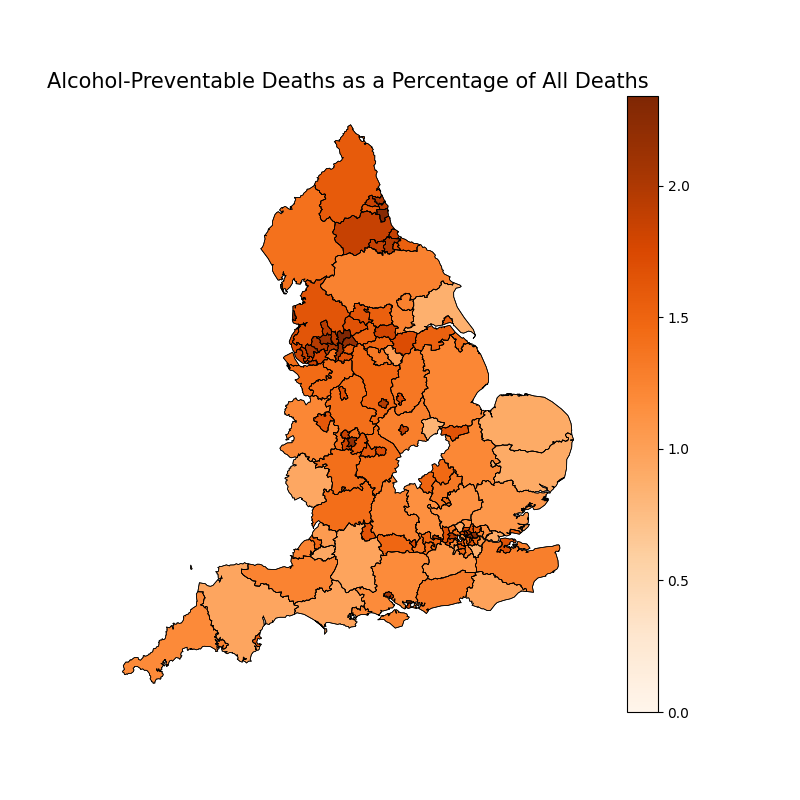

# Time Series Analysis of Preventable Deaths and Deprivation

1. **Rising Percentage of Preventable Deaths**:
   - The average percentage of preventable deaths in the UK has shown a steady increase over the years:
     - **2020**: On average, \(2.78\%\) of deaths were preventable.
     - **2021**: On average, \(3.05\%\) of deaths were preventable.
     - **2022**: On average, \(3.25\%\) of deaths were preventable.
   - This trend indicates that preventable deaths are on the rise.

2. **Impact of Deprivation**:
   - The increase in preventable deaths is particularly pronounced in areas of high deprivation:
     - **2020**: On average, \(3.42\%\) of deaths in high deprivation areas were preventable.
     - **2021**: On average, \(3.78\%\) of deaths in high deprivation areas were preventable.
     - **2022**: On average, \(4.11\%\) of deaths in high deprivation areas were preventable.

3. **Strengthening Correlation**:
   - Between 2020 and 2022, the correlation between deprivation and preventable deaths has become stronger:
     - **2020**: Spearman's correlation: \(-0.596\), Pearson's correlation: \(-0.579\)
     - **2021**: Spearman's correlation: \(-0.619\), Pearson's correlation: \(-0.616\)
     - **2022**: Spearman's correlation: \(-0.687\), Pearson's correlation: \(-0.669\)
   - These results suggest a significant and strengthening relationship between deprivation levels and the percentage of preventable deaths over the analyzed years.

This analysis highlights the critical need for targeted public health interventions in areas of high deprivation to address the rising trend of preventable deaths.


In [48]:
mean_percent_2020 = df_clean_percent[df_clean_percent['Year']== 2020]['Percentage of preventable'].mean().round(2)
print(f'In 2020, on average {mean_percent_2020}% of deaths in the UK were preventable.')
mean_percent_2021 = df_clean_percent[df_clean_percent['Year']== 2021]['Percentage of preventable'].mean().round(2)
print(f'In 2021, on average {mean_percent_2021}% of deaths in the UK were preventable.')
mean_percent_2022 = df_clean_percent[df_clean_percent['Year']== 2022]['Percentage of preventable'].mean().round(2)
print(f'In 2022, on average {mean_percent_2022}% of deaths in the UK were preventable.')

In 2020, on average 2.78% of deaths in the UK were preventable.
In 2021, on average 3.05% of deaths in the UK were preventable.
In 2022, on average 3.25% of deaths in the UK were preventable.


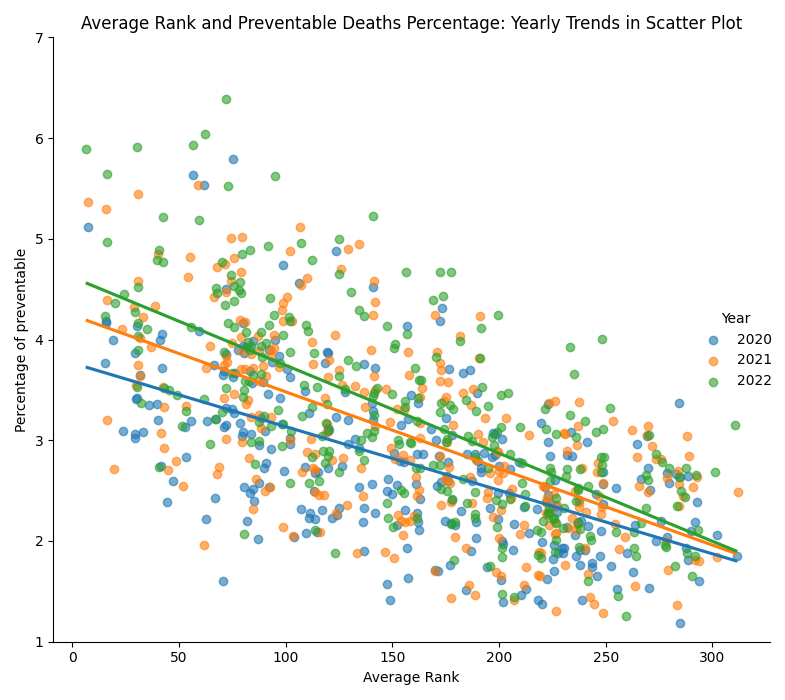

In [49]:
mean_high_dep_percent_2020 = df_clean_percent[(df_clean_percent['Average Rank Category'] == 'High')  \
                            & (df_clean_percent['Year'] == 2020)]['Percentage of preventable'].mean().round(2)
print(f'In 2020, on average {mean_high_dep_percent_2020}% of deaths in the areas of high deprivation were preventable.')

mean_high_dep_percent_2021 = df_clean_percent[(df_clean_percent['Average Rank Category'] == 'High')  \
                            & (df_clean_percent['Year'] == 2021)]['Percentage of preventable'].mean().round(2)
print(f'In 2021, on average {mean_high_dep_percent_2021}% of deaths in the areas of high deprivation were preventable.')

mean_high_dep_percent_2022 = df_clean_percent[(df_clean_percent['Average Rank Category'] == 'High')  \
                            & (df_clean_percent['Year'] == 2022)]['Percentage of preventable'].mean().round(2)
print(f'In 2022, on average {mean_high_dep_percent_2022}% of deaths in the areas of high deprivation were preventable.')

In 2020, on average 3.42% of deaths in the areas of high deprivation were preventable.
In 2021, on average 3.78% of deaths in the areas of high deprivation were preventable.
In 2022, on average 4.11% of deaths in the areas of high deprivation were preventable.


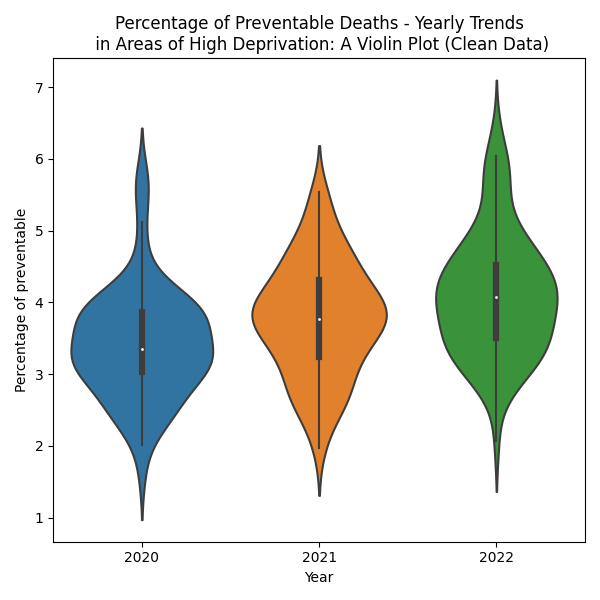

In [50]:
clean_2020 = df_clean_percent.copy()
clean_2020 = clean_2020[clean_2020['Year']== 2020]

clean_2021 = df_clean_percent.copy()
clean_2021 = clean_2021[clean_2021['Year']== 2021]

clean_2022 = df_clean_percent.copy()
clean_2022 = clean_2022[clean_2022['Year']== 2022]

spr2020 = scipy.stats.spearmanr(clean_2020['Average Rank'],clean_2020['Percentage of preventable'])[0]
pear2020 = scipy.stats.pearsonr(clean_2020['Average Rank'],clean_2020['Percentage of preventable'])[0]
spr2021 = scipy.stats.spearmanr(clean_2021['Average Rank'],clean_2021['Percentage of preventable'])[0]
pear2021 = scipy.stats.pearsonr(clean_2021['Average Rank'],clean_2021['Percentage of preventable'])[0]
spr2022 = scipy.stats.spearmanr(clean_2022['Average Rank'],clean_2022['Percentage of preventable'])[0]
pear2022 = scipy.stats.pearsonr(clean_2022['Average Rank'],clean_2022['Percentage of preventable'])[0]

print(f'2020 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: {spr2020.round(3)} and Pearsons: {pear2020.round(3)}')
print(f'2021 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: {spr2021.round(3)} and Pearsons: {pear2021.round(3)}')
print(f'2022 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: {spr2022.round(3)} and Pearsons: {pear2022.round(3)}')

2020 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: -0.596 and Pearsons: -0.579
2021 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: -0.619 and Pearsons: -0.616
2022 Correlation coefficients between average rank and percentage of preventable deaths Spearmans: -0.687 and Pearsons: -0.669


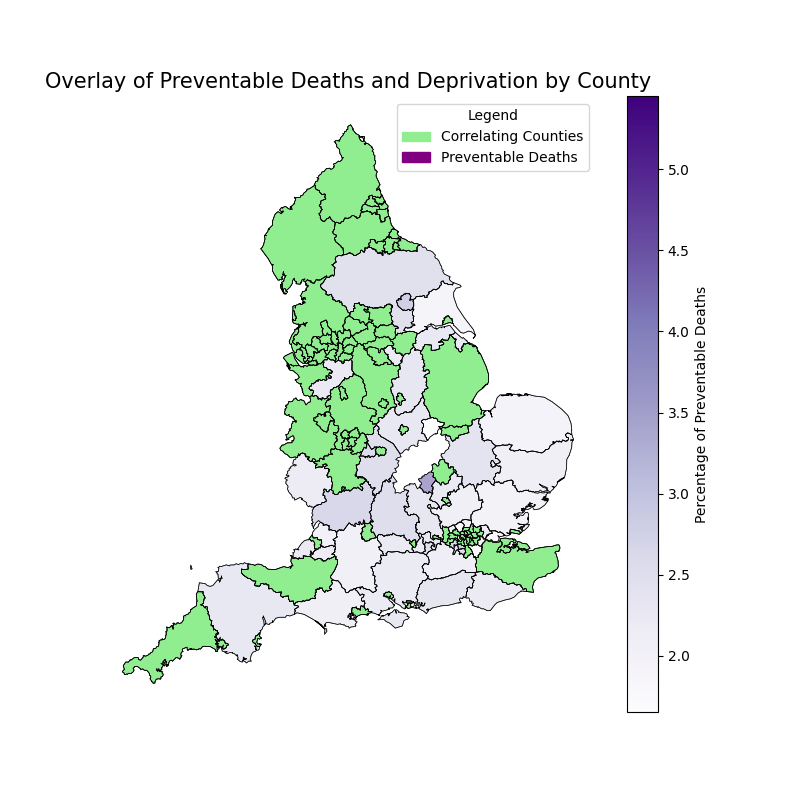

## Merging County Data with Geospatial Information


This process combines county deprivation data with geographic boundaries, creating a GeoDataFrame for spatial analysis and visualization.


In [51]:
shapefile_path = 'data/county boundaries.shp'
gdf = gpd.read_file(shapefile_path)

geo_merge_df = df_county_rank_clean.copy()
geo_merge_df = geo_merge_df.merge(gdf, left_on = 'County', right_on='ctyua19nm', how='inner')
geo_merge_df = gpd.GeoDataFrame(geo_merge_df, geometry='geometry')
print(geo_merge_df.columns)

geo_merge_df.head(2)

Index(['All causes', 'Health Deprivation Rank', 'Education Deprivation Rank',
       'Employment Deprivation Rank', 'Income Deprivation Rank', 'Crime Rank',
       'Living Environment Deprivation Rank', 'Average Rank', 'Assault %',
       'Self-harm %', 'Alcohol %', 'Poison & Toxic %', 'Drugs %',
       'Substance %', 'Percentage of preventable', 'Average Rank Category',
       'category_color', 'Preventable Category', 'ctyua19cd', 'ctyua19nm',
       'ctyua19nmw', 'bng_e', 'bng_n', 'long', 'lat', 'GlobalID', 'geometry'],
      dtype='object')


,All causes,Health Deprivation Rank,Education Deprivation Rank,Employment Deprivation Rank,Income Deprivation Rank,Crime Rank,Living Environment Deprivation Rank,Average Rank,Assault %,Self-harm %,...,Preventable Category,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,GlobalID,geometry
0,4213.0,61,21,31,4,18,33,28,0.0,0.854498,...,Medium,E09000002,Barking and Dagenham,None,547757,185111,0.129479,51.545551,d03864fd-4a92-4eb5-9bb3-5d4dbc318ab0,"POLYGON ((548881.299 187727.503, 549951.904 18..."
1,8204.0,146,145,119,91,82,50,105,0.0,0.414432,...,Low,E09000003,Barnet,None,523472,191753,-0.218210,51.611080,3921a178-5b8c-49e5-9712-beb551f97207,"POLYGON ((517435.197 194421.097, 520681.797 19..."


## Merging Regional Data with Geospatial Information


This process combines certain regions' mortality data to match geospacial data regions, to be merged with the geographic boundaries, creating a GeoDataFrame for spatial analysis and visualization.


In [52]:
shapefile_path2 = 'data/regions shape.shp'
gdf2 = gpd.read_file(shapefile_path2)

df_region2= df_region.copy()

regions_to_combine = {
    'Midlands': ['East Midlands', 'West Midlands'],
    'North East and Yorkshire': ['North East', 'Yorkshire and The Humber']
}

# Summing the specified regions and appending them to the DataFrame
for new_region, old_regions in regions_to_combine.items():
    new_row = df_region2.loc[df_region2['Region'].isin(old_regions)].sum(numeric_only=True)
    new_row['Region'] = new_region
    df_region2 = pd.concat([df_region2, pd.DataFrame([new_row])], ignore_index=True)

df_region2 = df_region2[~df_region2['Region'].isin([r for regions in regions_to_combine.values() for r in regions])]

df_region2.reset_index(drop=True, inplace=True)

df_region_percent2 = df_region2.copy()
df_region_percent2['Assault %'] = df_region_percent2['Assault'] / df_region_percent2['All causes'] * 100
df_region_percent2['Self-harm %'] = df_region_percent2['Intentional self-harm'] / df_region_percent2['All causes'] * 100
df_region_percent2['Alcohol %'] = df_region_percent2['Alcohol'] / df_region_percent2['All causes'] * 100
df_region_percent2['Poison & Toxic %'] = df_region_percent2['Poison & Toxic'] / df_region_percent2['All causes'] * 100
df_region_percent2['Drugs %'] = df_region_percent2['Drugs'] / df_region_percent2['All causes'] * 100
df_region_percent2['Substance %'] = df_region_percent2['Substance'] / df_region_percent2['All causes'] * 100
df_region_percent2['Percentage of preventable'] = (df_region_percent2['Alcohol'] + df_region_percent2['Drugs'] \
                                                 + df_region_percent2['Poison & Toxic'] + df_region_percent2['Substance'] \
                                                + df_region_percent2['Intentional self-harm']+ df_region_percent2['Assault'])/ df_region_percent2['All causes'] * 100
 
    
percent_cols_drop4 = ['Assault', 'Intentional self-harm', 'Alcohol', 'Poison & Toxic', 'Drugs', 'Substance']

df_region_percent2 = df_region_percent2.drop(columns=percent_cols_drop4)
print(df_region_percent2.shape)
df_region_percent2.sort_values(by='Percentage of preventable', ascending=False, inplace=True)
df_region_percent2

geo_region = df_region_percent2.copy()
geo_region = geo_region.merge(gdf2, left_on ='Region', right_on = 'NHSER24NM', how='inner')
geo_region = gpd.GeoDataFrame(geo_region, geometry='geometry')
geo_region.head(2)

(8, 9)


,Region,All causes,Assault %,Self-harm %,Alcohol %,Poison & Toxic %,Drugs %,Substance %,Percentage of preventable,NHSER24CD,NHSER24NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,North West,241575.0,0.016558,0.859774,1.748111,0.0,0.0,1.107317,3.73176,E40000014,North West,356889,444857,-2.65755,53.8981,9331a156-7bdc-4fc5-b423-508d47cfb1cc,"MULTIPOLYGON (((327828.613 373756.171, 327850...."
1,North East and Yorkshire,266498.0,0.017636,0.910701,1.577123,0.0,0.0,1.202260,3.70772,E40000012,North East and Yorkshire,388426,515856,-2.18039,54.5378,cdb0d616-a22c-46a9-95fd-95499bbe41b3,"MULTIPOLYGON (((528260.3 411429.3, 528172.42 4..."


# Final Summary 

## Geographic Insights:

The analysis reveals notable **regional differences** in preventable deaths across England, with a clear **North/South divide**. Regions such as **Manchester/Merseyside, the North East, the West Midlands, and Central London** exhibit clusters of high preventable deaths, whereas the **East of England and the South West** have comparatively lower rates.

A particularly striking finding emerges between the **North East and North West** regions when examining **alcohol and substance-related deaths**:
- **Alcohol-Related Deaths**: The **North West** shows the highest percentage of deaths due to alcohol, with the **North East** following as the second-highest region.
- **Substance-Related Deaths**: In contrast, the **North East** leads in substance-related deaths, while the **North West** holds the second-highest rate.

This difference between the North East and North West regions points to **distinct public health challenges**. The **North East struggles more with substance abuse**, while **alcohol-related deaths** present a greater challenge in the **North West**. These findings suggest the need for **tailored health interventions** targeting specific issues in these regions.

## Temporal Trends:

Preventable deaths have steadily increased over the years, particularly in **high deprivation areas**. In 2020, on average, **2.78%** of deaths were classified as preventable, increasing to **3.25% in 2022**. More worryingly, areas with high deprivation saw a sharper rise—from **3.42% in 2020** to **4.11% in 2022**—highlighting a growing disparity between deprived and less deprived areas.

## Strengthening Correlation:

Between **2020 and 2022**, the correlation between **deprivation** (average rank) and **preventable deaths** has become stronger:
- **2020**: Spearman's correlation: \(-0.596\), Pearson's correlation: \(-0.579\)
- **2021**: Spearman's correlation: \(-0.619\), Pearson's correlation: \(-0.616\)
- **2022**: Spearman's correlation: \(-0.687\), Pearson's correlation: \(-0.669\)

These results suggest a **significant and strengthening relationship** between deprivation levels and the percentage of preventable deaths **over the analyzed years**.

## Correlation Improvement After Cleaning Data

The analysis of correlation coefficients highlights the impact of data cleaning on achieving more accurate statistical relationships:

1. **Initial Correlation Coefficients** (before cleaning):
   - **County Data**: 
     - Spearman: **-0.659**
     - Pearson: **-0.618**
   - **Main Data**: 
     - Spearman: **-0.518**
     - Pearson: **-0.578**

2. **Post-Cleaning Correlation Coefficients** (after removing outliers):
   - **County Data**: 
     - Spearman: **-0.670**
     - Pearson: **-0.665**
   - **Main Data**: 
     - Spearman: **-0.619**
     - Pearson: **-0.608**

3. **Impact of Data Cleaning**:
   - Removing outliers and irrelevant data points resulted in **higher (more negative) correlation** values across both datasets. This suggests a stronger inverse relationship between 'Average Rank' and 'Percentage of Preventable'. This analysis emphasizes the importance of data cleaning in enhancing the accuracy of statistical correlations.

## Statistical Insights:

#### ANOVA:
Two **ANOVA tests** confirmed statistically significant differences in preventable deaths across **deprivation categories**:
- **Main Data**: F-statistic of **247.78** with a p-value of $6.78 \times 10^{-86}$.
- **County Data**: F-statistic of **46.95** with a p-value of $2.00 \times 10^{-16}$.

These results show that deprivation has a **statistically significant effect** on preventable death rates both nationally and at the county level.

#### Chi-Square Test:
Two **Chi-Square tests** examined the relationship between deprivation rank and preventable death categories. Both tests indicate a **strong association** between deprivation and preventable deaths:
- **Main Data**: Chi-Square value of **277.71** with a p-value of $6.93 \times 10^{-59}$.
- **County Data**: Chi-Square value of **66.30** with a p-value of $1.37 \times 10^{-13}$.

In both cases, the extremely small p-values lead to **rejection of the null hypothesis**, confirming that **deprivation rank is significantly associated** with the percentage of preventable deaths.

#### Cramér’s V:
Cramér’s V was calculated to measure the strength of the association between the categorical variables. The results indicate a **moderate association** between **deprivation rank** and **preventable deaths**:
- **Main Data**: **Cramér’s V = 0.3988**
- **County Data**: **Cramér’s V = 0.4749**

This moderate association confirms that deprivation plays a crucial role in influencing preventable deaths.

## Conclusion:

In summary, this analysis highlights the **growing trend of preventable deaths**, especially in **high deprivation areas**. The **North West** leads in overall preventable deaths and alcohol-related deaths, while the **North East** struggles more with substance-related deaths. The **strengthening correlation** between deprivation and preventable deaths underscores the need for effective public health interventions. Both **ANOVA and Chi-Square tests** confirm the significant association between deprivation and preventable deaths, underscoring the importance of **targeted public health interventions** to address the unique challenges in these regions.


## Correlation coefficient interpertation table

In [53]:

# # Define the data for the correlation coefficient interpretation table
# data = [
#     ["0.000 – 0.099", "Very Weak"],
#     ["0.100 – 0.299", "Weak"],
#     ["0.300 – 0.499", "Moderate"],
#     ["0.500 – 0.699", "Strong"],
#     ["0.700 – 1.000", "Very Strong"],
#     ["-0.000 – -0.099", "Very Weak"],
#     ["-0.100 – -0.299", "Weak"],
#     ["-0.300 – -0.499", "Moderate"],
#     ["-0.500 – -0.699", "Strong"],
#     ["-0.700 – -1.000", "Very Strong"],
# ]
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=data, colLabels=["Value of Correlation Coefficient", "Relationship Interpretation"],
#                  cellLoc='center', loc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(12)
# table.scale(1.2,2.0)

# plt.title("Correlation Coefficient Interpretation Table", fontsize=16)
# plt.savefig("Correlation Coefficient Interpretation Table")
# plt.show()


# County Geo-Plots

In [54]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Average Rank', ax=ax, legend=True,  \
#                   cmap='copper', edgecolor='black', linewidth=0.5)
# ax.set_title('Indicies of Deprivation by County (Average Rank)', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Indicies of Deprivation by County (Average Rank)')
# plt.show()

In [55]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Health Deprivation Rank', ax=ax, legend=True,  \
#                   cmap='copper', edgecolor='black', linewidth=0.5)
# ax.set_title('Indicies of Deprivation (Heath Deprivation Rank)', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Indicies of Deprivation (Heath Deprivation Rank)')
# plt.show()

In [56]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Percentage of preventable', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Percentage of Preventable Deaths by County', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Percentage of Preventable Deaths by County')
# plt.show()

In [57]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Substance %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Substance-Related Deaths as a Percentage of All Deaths', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Substance-Related Deaths as a Percentage of All Deaths')
# plt.show()

In [58]:
# threshold_preventable = geo_merge_df['Percentage of preventable'].quantile(0.25)
# threshold_deprivation = geo_merge_df['Average Rank'].quantile(0.75)

# correlation_mask = (geo_merge_df['Percentage of preventable'] > threshold_preventable) & \
#                    (geo_merge_df['Average Rank'] < threshold_deprivation)

# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# # geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black')

# # preventable_plot = geo_merge_df.plot(column='Percentage of preventable', ax=ax, legend=False,
# #                                       cmap='Purples', edgecolor='black', linewidth=0.5, alpha=0.6)

# # geo_merge_df[correlation_mask].plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.5, label='Correlating Counties')

# # sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=geo_merge_df['Percentage of preventable'].min(),
# #                                                                vmax=geo_merge_df['Percentage of preventable'].max()))

# # fig.colorbar(sm, ax=ax, orientation='vertical', label='Percentage of Preventable Deaths')


# # handles = [mpatches.Patch(color='lightgreen', label='Correlating Counties')]
# # handles.append(mpatches.Patch(color='purple', label='Preventable Deaths'))

# # ax.set_title('Overlay of Preventable Deaths and Deprivation by County', fontsize=15)
# # ax.set_axis_off()

# # ax.legend(handles=handles, loc='upper right', title='Legend', fontsize=10)

# # plt.savefig('Overlay of Preventable Deaths and Deprivation by County')
# # plt.show()


In [59]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Alcohol %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Alcohol-Preventable Deaths as a Percentage of All Deaths', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Alcohol-Preventable Deaths as a Percentage of All Deaths')
# plt.show()

In [60]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_merge_df.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_merge_df.plot(column='Self-harm %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Percentage of Total Deaths Attributable to Self-Harm',  fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Percentage of Total Deaths Attributable to Self-Harm')
# plt.show()


# Regional Geo-Plots


In [61]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_region.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_region.plot(column='Percentage of preventable', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Percentage of Preventable Deaths by Region', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Percentage of Preventable Deaths by Region')
# plt.show()

In [62]:
# fig, ax = plt.subplots(1, 1, figsize=(9, 8))
# geo_region.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_region.plot(column='Alcohol %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Alcohol-Preventable Deaths as a Percentage of All Deaths', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Alcohol-Preventable Deaths as a Percentage of All Deaths')
# plt.show()

In [63]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# geo_region.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_region.plot(column='Self-harm %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Percentage of Total Deaths Attributable to Self-Harm', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Percentage of Total Deaths Attributable to Self-Harm')
# plt.show()

In [64]:
# fig, ax = plt.subplots(1, 1, figsize=(9, 8))
# geo_region.boundary.plot(ax=ax, linewidth=0.5, color='black') 
# geo_region.plot(column='Substance %', ax=ax, legend=True,  \
#                   cmap='Oranges', edgecolor='black', linewidth=0.5)
# ax.set_title('Substance-Related Deaths as a Percentage of All Deaths', fontsize=15)
# ax.set_axis_off()  
# plt.savefig('Substance-Related Deaths as a Percentage of All Deaths')
# plt.show()

# Regression Plots Area

In [65]:
# yearly_data = df_grouped.groupby('Year').sum()

# filtered_years = yearly_data.loc[[2020, 2021, 2022], ['Alcohol', 'Substance','Intentional self-harm', 'Assault', 'Drugs', 'Poison & Toxic']]

# plt.figure(figsize=(6,6))
# filtered_years.plot(kind='bar', figsize=(10, 6), width=0.8)

# plt.title('Comparison of Preventable Deaths by Year (2020-2022)')
# plt.xlabel('Year')
# plt.ylabel('Total preventable deaths (yearly)')
# plt.xticks(rotation=0)
# plt.legend(['Alcohol', 'Substance','Intentional self-harm', 'Assault', 'Drugs', 'Poison & Toxic'], title='Preventable Cause')

# plt.savefig('Comparison of Preventable Deaths by Year (2020-2022)')
# plt.show()

In [66]:
# plt.figure(figsize=(7,6))
# sns.regplot(x='Average Rank', y='Percentage of preventable', data=df_percent, color='Red',scatter_kws={'alpha': 0.4}, line_kws={'color': 'black'})
# plt.title('Relationship Between Preventable Deaths and Average Deprivation Rank')
# plt.savefig('Relationship Between Preventable Deaths and Average Deprivation Rank')
# plt.show()

In [67]:
# plt.figure(figsize=(6,6))
# sns.kdeplot(data=df_percent['Percentage of preventable'], color='Red', fill=True)
# plt.title('Distribution of Percentage of Preventable Deaths')
# plt.savefig('Distribution of Percentage of Preventable Deaths')
# plt.show()

In [68]:
# plt.figure(figsize=(6,6))
# sns.violinplot(data=df_percent, x= 'Average Rank Category', order=('Low', 'Medium', 'High'), y= 'Percentage of preventable', fill=True )
# plt.title('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Raw Data)')
# plt.savefig('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Raw Data)')
# plt.show()

In [69]:
# plt.figure(figsize=(8,6))
# sns.violinplot(data=df_clean_percent, x= 'Average Rank Category', order=('Low', 'Medium', 'High'), y= 'Percentage of preventable', fill=True )
# plt.title('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Clean Data)')
# plt.savefig('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Clean Data)')
# plt.show()

In [70]:
# sns.lmplot(data=df_clean_percent, x='Average Rank', y='Percentage of preventable', hue='Year', x_jitter=True, height=7, aspect=28/28, ci=None, scatter_kws={'alpha': 0.6})
# plt.ylim(1,7)
# plt.title('Average Rank and Preventable Deaths Percentage: Yearly Trends in Scatter Plot')
# plt.tight_layout()  # Adjusts the layout
# plt.savefig('Average Rank and Preventable Deaths Percentage: Yearly Trends in Scatter Plot')
# plt.show()

In [71]:
# plt.figure(figsize=(6,6))
# sns.kdeplot(data=df_clean_percent, x= 'Percentage of preventable',hue='Year')
# plt.title('Distribution of Percentage of Preventable Deaths - Yearly Trends')
# plt.savefig('Distribution of Percentage of Preventable Deaths - Yearly Trends')
# plt.show()


In [72]:
# plt.figure(figsize=(+7,6))
# sns.violinplot(data=df_percent, x= 'Year', y= 'Percentage of preventable', fill=True )
# plt.title('Percentage of Preventable Deaths - Yearly Trends: A Violin Plot (Raw Data)')
# plt.tight_layout()  
# plt.savefig('Percentage of Preventable Deaths - Yearly Trends: A Violin Plot (Raw Data)')
# plt.show()

In [73]:
# plt.figure(figsize=(6,6))
# sns.violinplot(data=df_clean_percent[df_clean_percent['Average Rank Category']=='High'], x= 'Year', y= 'Percentage of preventable', fill=True )
# plt.title('Percentage of Preventable Deaths - Yearly Trends\n in Areas of High Deprivation: A Violin Plot (Clean Data)')
# plt.tight_layout()
# plt.savefig('Percentage of Preventable Deaths - Yearly Trends in Areas of High Deprivation: A Violin Plot (Clean Data)')
# plt.show()

In [74]:
# plt.figure(figsize=(8,6))
# sns.violinplot(data=df_county_percent, x= 'Average Rank Category', order=('Low', 'Medium', 'High'), y= 'Percentage of preventable', fill=True )
# plt.title('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Raw County Data)')
# plt.savefig('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Raw County Data)')
# plt.show()

In [75]:
# plt.figure(figsize=(6,6))
# sns.violinplot(data=df_county_rank_clean, x= 'Average Rank Category', order=('Low', 'Medium', 'High'), y= 'Percentage of preventable', fill=True )
# plt.title('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Clean County Data)')
# plt.savefig('Average Rank and its Impact on Percentage of Preventable Deaths: A Violin Plot (Clean County Data)')
# plt.show()

In [76]:
# plt.figure(figsize=(7,6))
# sns.regplot(x='Average Rank', y='Percentage of preventable', ci=None, data=df_county_percent,color='Red',scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
# plt.title('Relationship Between Preventable Deaths and Average Deprivation Rank (County)')
# plt.savefig('Relationship Between Preventable Deaths and Average Deprivation Rank (County)')
# plt.show()

In [77]:
# plt.figure(figsize=(6,6))
# sns.kdeplot(data=df_county_percent['Percentage of preventable'], fill=True, color='Red')
# plt.title('Distribution of Percentage of Preventable Deaths (County)')
# plt.savefig('Distribution of Percentage of Preventable Deaths (County)')
# plt.show()